# Bài toán Delay Probability Prediction

## Import libraries and load the dataset

In [4]:
!pip install kagglehub

In [5]:
!pip install holidays

In [6]:
!pip install lightgbm

In [7]:
!pip install xgboost

In [8]:
!pip install boruta

In [2]:
# Imported Libraries
import kagglehub
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import holidays
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib as mpl
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib.cm as cm
import plotly.graph_objects as go

# Classifier Libraries
from sklearn.linear_model import LogisticRegression

# Other Libraries
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import *

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
# Download dữ liệu từ kagglehub
path = kagglehub.dataset_download("datasetengineer/logistics-and-supply-chain-dataset")
print(os.listdir(path))

['dynamic_supply_chain_logistics_dataset.csv']


In [5]:
# Đọc file CSV và print điểm dữ liệu mẫu 
csv_file = os.path.join(path, "dynamic_supply_chain_logistics_dataset.csv")
df = pd.read_csv(csv_file)
df.head()

timestamp  vehicle_gps_latitude  vehicle_gps_longitude  \
0  2021-01-01 00:00:00             40.375568             -77.014318   
1  2021-01-01 01:00:00             33.507818            -117.036902   
2  2021-01-01 02:00:00             30.020640             -75.269224   
3  2021-01-01 03:00:00             36.649223             -70.190529   
4  2021-01-01 04:00:00             30.001279             -70.012195   

   fuel_consumption_rate  eta_variation_hours  traffic_congestion_level  \
0               5.136512             4.998009                  5.927586   
1               5.101512             0.984929                  1.591992   
2               5.090803             4.972665                  8.787765   
3               8.219558             3.095064                  0.045257   
4               5.000075             3.216077                  8.004851   

   warehouse_inventory_level  loading_unloading_time  \
0                 985.716862                4.951392   
1                 396.700206                1.030379   
2                 832.408935                4.220229   
3                   0.573283                0.530186   
4                 914.925067                3.620890   

   handling_equipment_availability  order_fulfillment_status  ...  \
0                         0.481294                  0.761166  ...   
1                         0.620780                  0.196594  ...   
2                         0.810933                  0.152742  ...   
3                         0.008525                  0.811885  ...   
4                         0.020083                  0.053659  ...   

   iot_temperature  cargo_condition_status  route_risk_level  \
0         0.574400                0.777263          1.182116   
1        -9.753493                0.091839          9.611988   
2        -6.491034                0.253529          6.570431   
3        -0.151276                0.877576          0.548952   
4         2.429448                0.262081          8.861443   

   customs_clearance_time  driver_behavior_score  fatigue_monitoring_score  \
0                0.502006               0.033843                  0.978599   
1                0.966774               0.201725                  0.918586   
2                0.945627               0.264045                  0.394215   
3                4.674035               0.362885                  0.905444   
4                3.445429               0.016957                  0.258702   

   disruption_likelihood_score  delay_probability  risk_classification  \
0                     0.506152           0.885291        Moderate Risk   
1                     0.980784           0.544178            High Risk   
2                     0.998633           0.803322            High Risk   
3                     0.993320           0.025977            High Risk   
4                     0.912433           0.991122            High Risk   

   delivery_time_deviation  
0                 9.110682  
1                 8.175281  
2                 1.283594  
3                 9.304897  
4                 7.752484  

[5 rows x 26 columns]

**Giải thích**:

- **Timestamp**: The date and time when the data was recorded (hourly resolution).
- **Vehicle GPS Latitude**: The latitude coordinate indicating the location of the vehicle.
- **Vehicle GPS Longitude**: The longitude coordinate indicating the location of the vehicle.
- **Fuel Consumption Rate**: The rate of fuel consumption recorded for the vehicle in liters per hour.
- **ETA Variation (hours)**: The difference between the estimated and actual arrival times.
- **Traffic Congestion Level**: The level of traffic congestion affecting the logistics route (scale 0-10).
- **Warehouse Inventory Level**: The current inventory levels at the warehouse (units).
- **Loading/Unloading Time**: The time taken for loading or unloading operations in hours.
- **Handling Equipment Availability**: Availability status of equipment like forklifts (0 = unavailable, 1 = available).
- **Order Fulfillment Status**: Status indicating whether the order was fulfilled on time (0 = not fulfilled, 1 = fulfilled).
- **Weather Condition Severity**: The severity of weather conditions affecting operations (scale 0-1).
- **Port Congestion Level**: The level of congestion at the port (scale 0-10).
- **Shipping Costs**: The costs associated with the shipping operations in USD.
- **Supplier Reliability Score**: A score indicating the reliability of the supplier (scale 0-1).
- **Lead Time (days)**: The average time taken for a supplier to deliver materials.
- **Historical Demand**: The historical demand for logistics services (units).
- **IoT Temperature**: The temperature recorded by IoT sensors in degrees Celsius.
- **Cargo Condition Status**: Condition status of the cargo based on IoT monitoring (0 = poor, 1 = good).
- **Route Risk Level**: The risk level associated with a particular logistics route (scale 0-10).
- **Customs Clearance Time**: The time required to clear customs for shipments.
- **Driver Behavior Score**: An indicator of the driver's behavior based on driving patterns (scale 0-1).
- **Fatigue Monitoring Score**: A score indicating the level of driver fatigue (scale 0-1).

## Dataset Overview

In [8]:
# Drop một số target variables mà bài toán không cần dùng tới
df.columns = df.columns.str.strip()
df.drop(['risk_classification', 'disruption_likelihood_score', 'delivery_time_deviation'], axis=1, errors='ignore', inplace = True)
df.head()

timestamp  vehicle_gps_latitude  vehicle_gps_longitude  \
0  2021-01-01 00:00:00             40.375568             -77.014318   
1  2021-01-01 01:00:00             33.507818            -117.036902   
2  2021-01-01 02:00:00             30.020640             -75.269224   
3  2021-01-01 03:00:00             36.649223             -70.190529   
4  2021-01-01 04:00:00             30.001279             -70.012195   

   fuel_consumption_rate  eta_variation_hours  traffic_congestion_level  \
0               5.136512             4.998009                  5.927586   
1               5.101512             0.984929                  1.591992   
2               5.090803             4.972665                  8.787765   
3               8.219558             3.095064                  0.045257   
4               5.000075             3.216077                  8.004851   

   warehouse_inventory_level  loading_unloading_time  \
0                 985.716862                4.951392   
1                 396.700206                1.030379   
2                 832.408935                4.220229   
3                   0.573283                0.530186   
4                 914.925067                3.620890   

   handling_equipment_availability  order_fulfillment_status  ...  \
0                         0.481294                  0.761166  ...   
1                         0.620780                  0.196594  ...   
2                         0.810933                  0.152742  ...   
3                         0.008525                  0.811885  ...   
4                         0.020083                  0.053659  ...   

   supplier_reliability_score  lead_time_days  historical_demand  \
0                    0.986064        2.128009         100.772854   
1                    0.463233       12.608166        5313.738114   
2                    0.598561       14.124452        1595.049146   
3                    0.742735        3.818972        2530.431941   
4                    0.431088       14.001491        2146.190197   

   iot_temperature  cargo_condition_status  route_risk_level  \
0         0.574400                0.777263          1.182116   
1        -9.753493                0.091839          9.611988   
2        -6.491034                0.253529          6.570431   
3        -0.151276                0.877576          0.548952   
4         2.429448                0.262081          8.861443   

   customs_clearance_time  driver_behavior_score  fatigue_monitoring_score  \
0                0.502006               0.033843                  0.978599   
1                0.966774               0.201725                  0.918586   
2                0.945627               0.264045                  0.394215   
3                4.674035               0.362885                  0.905444   
4                3.445429               0.016957                  0.258702   

   delay_probability  
0           0.885291  
1           0.544178  
2           0.803322  
3           0.025977  
4           0.991122  

[5 rows x 23 columns]

In [22]:
df.columns

Index(['timestamp', 'vehicle_gps_latitude', 'vehicle_gps_longitude',
       'fuel_consumption_rate', 'eta_variation_hours',
       'traffic_congestion_level', 'warehouse_inventory_level',
       'loading_unloading_time', 'handling_equipment_availability',
       'order_fulfillment_status', 'weather_condition_severity',
       'port_congestion_level', 'shipping_costs', 'supplier_reliability_score',
       'lead_time_days', 'historical_demand', 'iot_temperature',
       'cargo_condition_status', 'route_risk_level', 'customs_clearance_time',
       'driver_behavior_score', 'fatigue_monitoring_score',
       'delay_probability'],
      dtype='object')

In [38]:
# Kiểm tra shape của tập dữ liệu
df.shape

(32065, 23)

**Brief conclusion:** Dataset has 32065 data points and 23 fields.

In [41]:
# Một số thông tin cơ bản của các trường dữ liệu: dạng dữ liệu, ô dữ liệu có giá trị,...
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32065 entries, 0 to 32064
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   timestamp                        32065 non-null  object 
 1   vehicle_gps_latitude             32065 non-null  float64
 2   vehicle_gps_longitude            32065 non-null  float64
 3   fuel_consumption_rate            32065 non-null  float64
 4   eta_variation_hours              32065 non-null  float64
 5   traffic_congestion_level         32065 non-null  float64
 6   warehouse_inventory_level        32065 non-null  float64
 7   loading_unloading_time           32065 non-null  float64
 8   handling_equipment_availability  32065 non-null  float64
 9   order_fulfillment_status         32065 non-null  float64
 10  weather_condition_severity       32065 non-null  float64
 11  port_congestion_level            32065 non-null  float64
 12  shipping_costs    

**Brief conclusion:**

- Number of Entries: The dataset consists of 32065 entries, ranging from index 0 to 32065.
- Columns: There are 22 columns in the dataset corresponding to various attributes of the patients and results of tests.
- Data Types: Most of the columns (23 out of 25) are of the float64 data type, except for timestamp and risk_classification.
- Missing Values: There don't appear to be any missing values in the dataset as each column has 32065 non-null entries.

In [63]:
# Kiểm tra tập dữ liệu có duplicated row không
df.duplicated().sum()

0

**Brief conclusion:** Number of duplicated rows: There don't appear to be any duplicated rows in the dataset.

In [48]:
# Kiểm tra tập dữ liệu có bao nhiêu giá trị unique
summary = pd.DataFrame({
    'missing': df.isnull().sum(),
    'unique': df.nunique(),
    'total': df.shape[0]
})

summary['unique_pct'] = (summary['unique'] / summary['total'] * 100).round(2)

print(summary)

                                 missing  unique  total  unique_pct
timestamp                              0   32065  32065      100.00
vehicle_gps_latitude                   0   32065  32065      100.00
vehicle_gps_longitude                  0   32065  32065      100.00
fuel_consumption_rate                  0   32037  32065       99.91
eta_variation_hours                    0   32065  32065      100.00
traffic_congestion_level               0   32065  32065      100.00
warehouse_inventory_level              0   32065  32065      100.00
loading_unloading_time                 0   32065  32065      100.00
handling_equipment_availability        0   32065  32065      100.00
order_fulfillment_status               0   32065  32065      100.00
weather_condition_severity             0   32065  32065      100.00
port_congestion_level                  0   32065  32065      100.00
shipping_costs                         0   32065  32065      100.00
supplier_reliability_score             0   32065

**Brief conclusion:** All fields have more than 99% unique data values, it's understandable as measurement variables often in float format. During data transformation, some processing steps can be applied, such as rounding values or using binning to reduce dispersion and gain an overall understanding of the data fields.

In [10]:
# Đánh giá phân bổ của các trường thông tin dạng float 
float_df = df.select_dtypes(include=['float64'])
stats = float_df.describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95, 0.99]).transpose().assign(
    cv=lambda x: 100.00 * x['std'] / x['mean']
)
stats

count         mean          std  \
vehicle_gps_latitude             32065.0    38.023589     6.917909   
vehicle_gps_longitude            32065.0   -90.116648    17.369244   
fuel_consumption_rate            32065.0     8.011735     4.264960   
eta_variation_hours              32065.0     2.893068     2.274044   
traffic_congestion_level         32065.0     4.991493     3.532048   
warehouse_inventory_level        32065.0   299.254732   323.443513   
loading_unloading_time           32065.0     2.291669     1.554202   
handling_equipment_availability  32065.0     0.302695     0.325915   
order_fulfillment_status         32065.0     0.600740     0.345672   
weather_condition_severity       32065.0     0.497608     0.353285   
port_congestion_level            32065.0     6.978414     3.251051   
shipping_costs                   32065.0   459.374452   312.183487   
supplier_reliability_score       32065.0     0.500850     0.353528   
lead_time_days                   32065.0     5.227502     4.523085   
historical_demand                32065.0  6022.001286  3427.638017   
iot_temperature                  32065.0     0.044792    14.187486   
cargo_condition_status           32065.0     0.297282     0.321611   
route_risk_level                 32065.0     7.001144     3.236328   
customs_clearance_time           32065.0     2.296448     1.555932   
driver_behavior_score            32065.0     0.498391     0.354159   
fatigue_monitoring_score         32065.0     0.600872     0.345810   
delay_probability                32065.0     0.699077     0.324514   

                                          min          25%          50%  \
vehicle_gps_latitude             3.000000e+01    31.280550    36.413820   
vehicle_gps_longitude           -1.200000e+02  -106.253913   -86.293414   
fuel_consumption_rate            5.000000e+00     5.019984     5.636036   
eta_variation_hours             -1.999993e+00     1.185744     3.882059   
traffic_congestion_level         1.091633e-09     1.474720     4.981244   
warehouse_inventory_level        1.322210e-12    16.051635   157.288022   
loading_unloading_time           5.000000e-01     0.774798     1.917121   
handling_equipment_availability  4.565769e-16     0.017108     0.159515   
order_fulfillment_status         1.317764e-06     0.277096     0.680553   
weather_condition_severity       4.536949e-09     0.144014     0.496178   
port_congestion_level            1.778665e-06     4.513889     8.383225   
shipping_costs                   1.000000e+02   154.017124   388.996911   
supplier_reliability_score       6.904319e-10     0.145316     0.503266   
lead_time_days                   1.000000e+00     1.237490     3.297654   
historical_demand                1.000030e+02  2822.607616  6785.123209   
iot_temperature                 -1.000000e+01    -9.931074    -7.858681   
cargo_condition_status           7.255415e-19     0.016783     0.154976   
route_risk_level                 4.968185e-05     4.593407     8.385605   
customs_clearance_time           5.000000e-01     0.776166     1.938273   
driver_behavior_score            4.043927e-09     0.144357     0.498847   
fatigue_monitoring_score         3.269508e-07     0.278315     0.683113   
delay_probability                3.128746e-06     0.456009     0.839599   

                                         75%          90%          95%  \
vehicle_gps_latitude               44.453655    48.698604    49.606658   
vehicle_gps_longitude             -73.079367   -70.318129   -70.055658   
fuel_consumption_rate               9.669944    15.676118    18.042072   
eta_variation_hours                 4.884355     4.994520     4.999430   
traffic_congestion_level            8.534902     9.760916     9.939158   
warehouse_inventory_level         540.597991   852.678949   944.699949   
loading_unloading_time              3.734188     4.692796     4.899758   
handling_equipment_availability     0.553595     0.860995     0.943382   
order_fulfillment_status        

**Brief conclusion:** Calculating the coefficient of variation (CV = std/mean) from the standard deviation relative to the mean shows that the data is widely dispersed, with many values far from the mean and a moderate to high level of variability.

In [107]:
# Đánh giá IQR và xác định liệu các trường thông tin có outliers không
Q1 = df[float_feature_variables].quantile(0.25)
Q3 = df[float_feature_variables].quantile(0.75)
IQR = Q3 - Q1

outliers_mask = (df[float_feature_variables] < (Q1 - 1.5 * IQR)) | (df[float_feature_variables] > (Q3 + 1.5 * IQR))
outliers_count_specified = outliers_mask.sum()
outliers_min = df[float_feature_variables][outliers_mask].min()
outliers_max = df[float_feature_variables][outliers_mask].max()

outliers_df = pd.DataFrame({
    'Outliers Count': outliers_count_specified,
    'Outliers Min': outliers_min,
    'Outliers Max': outliers_max,
    'Outliers Percentage': ((outliers_count_specified / len(df)) * 100).round(2)
})

outliers_df

Outliers Count  Outliers Min  Outliers Max  Outliers Percentage
vehicle_gps_latitude                          0           NaN           NaN                 0.00
vehicle_gps_longitude                         0           NaN           NaN                 0.00
fuel_consumption_rate                      2536       16.6452       19.9999                 7.91
eta_variation_hours                           0           NaN           NaN                 0.00
traffic_congestion_level                      0           NaN           NaN                 0.00
warehouse_inventory_level                     0           NaN           NaN                 0.00
loading_unloading_time                        0           NaN           NaN                 0.00
handling_equipment_availability               0           NaN           NaN                 0.00
order_fulfillment_status                      0           NaN           NaN                 0.00
weather_condition_severity                    0           NaN           NaN                 0.00
port_congestion_level                         0           NaN           NaN                 0.00
shipping_costs                                0           NaN           NaN                 0.00
supplier_reliability_score                    0           NaN           NaN                 0.00
lead_time_days                                0           NaN           NaN                 0.00
historical_demand                             0           NaN           NaN                 0.00
iot_temperature                            2301       29.9599       39.9999                 7.18
cargo_condition_status                        0           NaN           NaN                 0.00
route_risk_level                              0           NaN           NaN                 0.00
customs_clearance_time                        0           NaN           NaN                 0.00
driver_behavior_score                         0           NaN           NaN                 0.00
fatigue_monitoring_score                      0           NaN           NaN                 0.00

**Brief Conclusion:**

- **iot_temperature**: This feature has an exceptionally high coefficient of variation. The IQR (Interquartile Range) analysis indicates that approximately 7.18% of values fall outside the lower and upper bounds. However, from a meaningful perspective, temperature (measured in Celsius) ranging from -1°C to 40°C is reasonable and can be valuable for probability forecasting and evaluation.

- **fuel_consumption_rate**: It represents the vehicle’s fuel consumption in liters per 100 kilometers (L/100km). Average fuel consumption levels for different vehicle types in the US (reference: https://afdc.energy.gov/data/10310) show that on average, a delivery truck consumes 6.8 gallons/km, equivalent to 25.74 liters/km. Hence, a value in range of 16 to 20 liters/km is reasonable, and its fluctuations may be attributed to urban vs. suburban conditions or varying vehicle fuel efficiency, as this metric varies due to multiple factors such as environmental impact, vehicle age, driving speed, etc. For instance, data from the United Kingdom indicates that urban fuel consumption can be 20‐50% higher than the combined value. Most vehicles consume significantly more fuel in urban conditions due to low average speeds (19 km/h), idle time (30%), and frequent stop/start events (reference: https://www.greenvehicleguide.gov.au/pages/ToolsAndCalculators/FuelConsumptionLabel).

Therefore, the values will be retained and not considered outliers.

In [110]:
# Đánh giá các trường thông tin object
df.describe(include='object').transpose()

count unique                  top freq
timestamp  32065  32065  2021-01-01 00:00:00    1

**Brief conclusion:** The dataset contains only one object-type field in datetime format, so there is no need to perform EDA techniques for categorical features.

## Exploratory Data Analysis

### Univariate Analysis

#### Target Variables

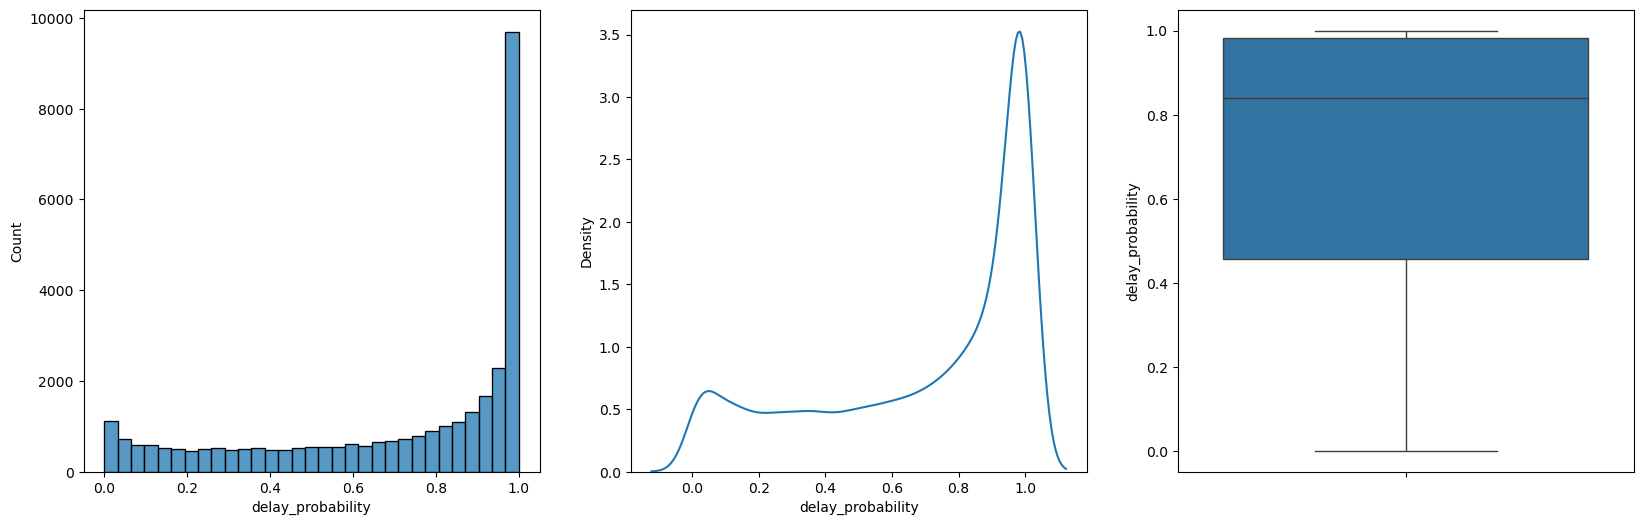

In [12]:
# Target Analysis

target_variable = 'delay_probability'

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(df[target_variable],ax=axs[0])
sns.kdeplot(df[target_variable],ax=axs[1])
sns.boxplot(df[target_variable], ax=axs[2])

plt.show()

**Brief conclusion:** The number of shipments in the high delay probability bin is significantly higher than in the others, indicating an imbalance in the data.

#### Float Feature Variables: Employ histograms to understand the central tendency, spread, and shape of the variables' distribution.

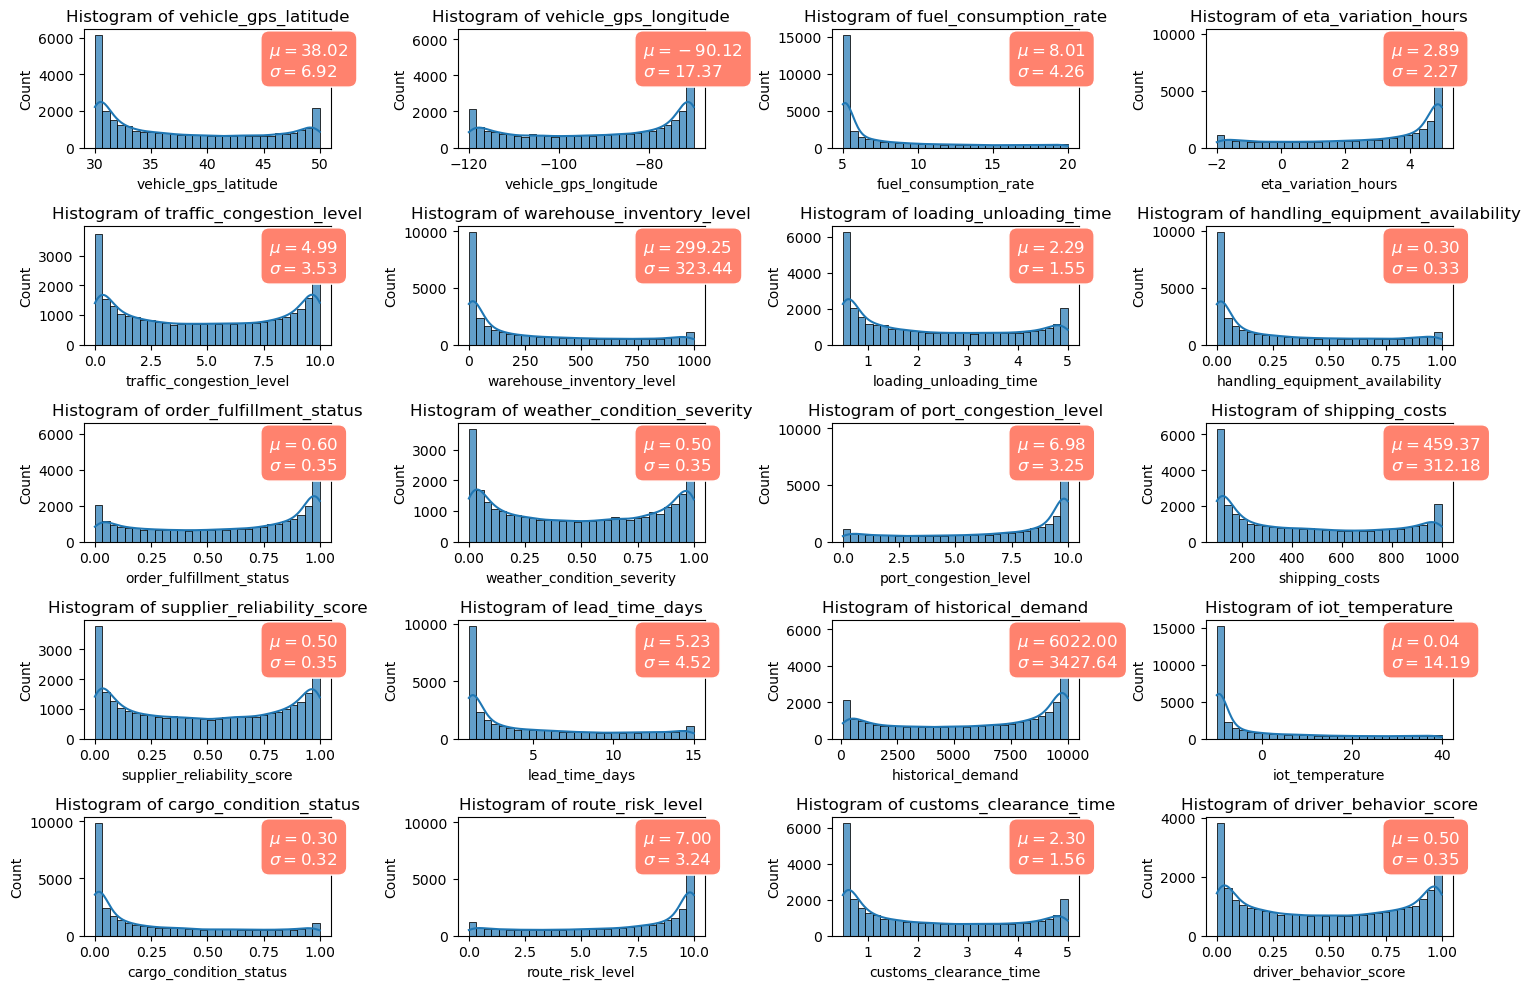

In [14]:
# Đánh giá phân bổ của các continous features 

float_variables = [col for col in df.select_dtypes(include=['float64']).columns.tolist()]
float_variables_df = df[float_variables]

float_feature_variables = [
    col for col in df.select_dtypes(include=['float64']).columns.tolist()
    if col not in ['delay_probability']
]
float_feature_variables_df = df[float_feature_variables]

plt.figure(figsize=(15, 10))

for i, col in enumerate(float_feature_variables):
    if i < 20:
        plt.subplot(5, 4, i + 1)
        sns.histplot(df[col], kde=True, bins=30, alpha=0.7)

        plt.title(f'Histogram of {col}')
        plt.text(
            0.75, 0.9, 
            fr"$\mu={df[col].mean():.2f}$" "\n" fr"$\sigma={df[col].std():.2f}$", 
            transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', color='white',
            bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5)
        )

        plt.grid(False)

plt.tight_layout()
plt.show()

In [18]:
skewness = float_feature_variables_df.skew()

positive_skew_columns = skewness[skewness > 0].index.tolist()
negative_skew_columns = skewness[skewness < 0].index.tolist()

print(skewness)
print("Columns with positive skewness:", positive_skew_columns)
print("Columns with negative skewness:", negative_skew_columns)

vehicle_gps_latitude               0.383415
vehicle_gps_longitude             -0.372547
fuel_consumption_rate              1.415944
eta_variation_hours               -0.819834
traffic_congestion_level           0.007640
warehouse_inventory_level          0.827780
loading_unloading_time             0.390971
handling_equipment_availability    0.808054
order_fulfillment_status          -0.385854
weather_condition_severity         0.008677
port_congestion_level             -0.813453
shipping_costs                     0.387397
supplier_reliability_score        -0.008788
lead_time_days                     0.807769
historical_demand                 -0.376473
iot_temperature                    1.405043
cargo_condition_status             0.835135
route_risk_level                  -0.827798
customs_clearance_time             0.385924
driver_behavior_score              0.002583
fatigue_monitoring_score          -0.389966
dtype: float64
Columns with positive skewness: ['vehicle_gps_latitude', 'fue

**The distribution of all features in dataset has 2 kind: skewed or U-shaped distribution.**

**1, U-Shaped Distribution**

A U-Shaped distribution is a bimodal distribution with frequencies that steadily fall and then steadily rise. There is a higher chance of a measurement being found at the extremes than in the center of the distribution. 
In some ways, this distribution can be thought of as an upside down bell curve. However, a U-shaped distribution can’t be turned into a bell curve by a meaningful transformation, even if it is perfectly symmetric (Iversen & Norpoth, 1987).

A symmetric U-shaped distribution has the following characteristics:

- Tails are equal on both sides.
- Coefficient of skewness is zero.
- The mean is less than the highest mode.
- The mean is equal to the median.
- Quartiles are defined as (Q3 – Md) = Md – Q1). In other words, the difference between the third quartile and the median equals the difference between the first quartile and the median.

In machine learning, non-linear tree-based models (e.g., XGBoost, Random Forest) handle U-shaped distributions better than linear models.

**2, Skewness**

All features show skewness. We need some transformation to normal the features:
- Positively Skewed Features: Some transformation technique should apply:
  + Log Transformation: Effectively minimizing large-scale differences by taking the natural log of all data points.
  + Square Root Transformation: A softer approach than the log transformation, ideal for moderately skewed data.
  + Box-Cox Transformation: Optimizing the transformation parameter lambda (λ), applicable only to positive data.
  + Yeo-Johnson Transformation: Similar to Box-Cox but adaptable to both positive and non-positive data.
  + Quantile transformation: Maps data to a specified distribution, such as normal, effectively addresses skewness by distributing the data points evenly across the chosen distribution. This transformation normalizes the shape of the data, focusing on making the distribution more uniform or Gaussian-like without assuming it will directly benefit linear models due to its non-linear nature and the challenge of reverting the data to its original form.

- Negatively Skewed Features: Some transformation technique should apply:
  + Power Transformations: Distributions that are left skew may be made more symmetric by taking a power (greater than 1), or by exponentiating. If it has an obvious upper bound, one might subtract observations from the upper bound (giving a right skewed result) and then attempt to transform that.
  + Squared Transformation: Taking each data point in the dataset and squaring it (i.e., raising it to the power of 2), useful for reducing negative skewness because it tends to spread out the lower values more than the higher values. However, it’s more effective when all data points are positive and the degree of negative skewness is not extreme.
  + Cubed Transformation: Similar to the squared transformation but involves raising each data point to the power of 3.
  + Box-Cox Transformation: A more sophisticated method that finds the best lambda (λ) parameter to transform the data into a normal shape.
  + Yeo-Johnson Transformation: Similar to the Box-Cox transformation, but the Yeo-Johnson is designed to handle both positive and negative data.
  + Quantile Transformation: This method transforms the features to follow a specified distribution, such as the normal distribution, based on their quantiles. It does not assume any specific distribution shape for the input data.
  
**Reference:**

- https://machinelearningmastery.com/skewness-be-gone-transformative-tricks-for-data-scientists
- https://stats.stackexchange.com/questions/107610/what-is-the-reason-the-log-transformation-is-used-with-right-skewed-distributionstribution

#### Object Feature Variables: Extract date-related features and time-series visualization

In [185]:
# Transform trường timestamp thành các giá trị thời gian khác như month, day, date, weekday,... để phân tích data có time-depedent không
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['date'] = df['timestamp'].dt.date
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
df['is_holiday'] = df['date'].apply(lambda x: 1 if x in holidays.UnitedStates() else 0)

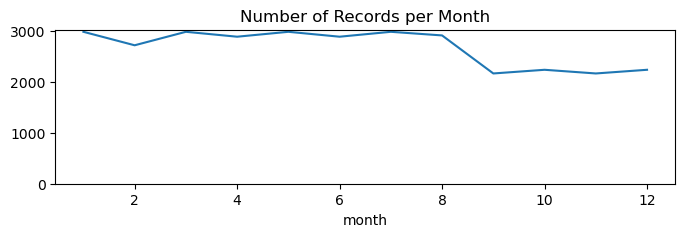

In [234]:
# Phân bổ dữ liệu theo tháng
date_counts = df.groupby('month').size()

plt.figure(figsize=(8, 2))
date_counts.plot(kind='line')

plt.title("Number of Records per Month")
plt.ylim(bottom=0)

plt.show()

In [36]:
total_records = len(df)
jan_to_aug_pct = (df['month'].between(1, 8).mean() * 100).round(2)
sep_to_dec_pct = (100 - jan_to_aug_pct).round(2)

jan_to_aug_pct, sep_to_dec_pct

(72.61, 27.39)

The dataset contains a high concentration of records from January to August, accounting for up to 72% of the total records.

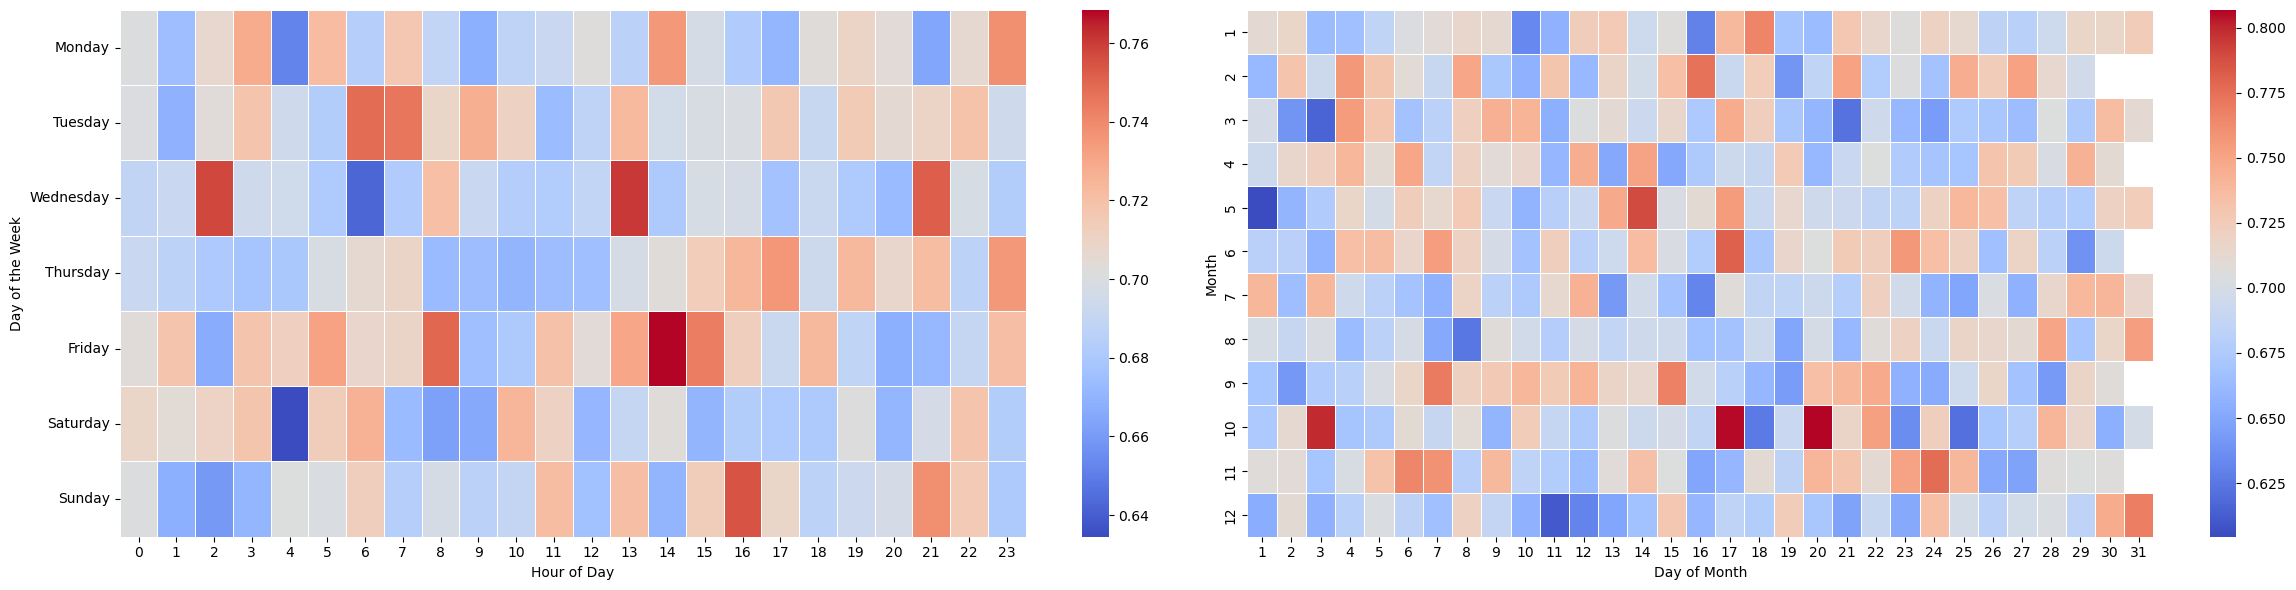

In [209]:
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

### Heatmap 1: Đánh giá liệu có ý nghĩa tương quan nào giữa giờ giao và ngày trong tuần với xác suất đơn hàng bị delay không
heatmap_data1 = df.pivot_table(index="weekday", columns="hour", values="delay_probability")
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data1 = heatmap_data1.reindex(day_order)
sns.heatmap(heatmap_data1, cmap="coolwarm", annot=False, linewidths=0.5, ax=axes[0])
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Day of the Week")

### Heatmap 2: Đánh giá liệu có ý nghĩa tương quan nào giữa ngày trong tháng và tháng với xác suất đơn hàng bị delay không
heatmap_data2 = df.pivot_table(index="month", columns="day", values="delay_probability")
sns.heatmap(heatmap_data2, cmap="coolwarm", annot=False, linewidths=0.5, ax=axes[1])
axes[1].set_xlabel("Day of Month")
axes[1].set_ylabel("Month")

plt.tight_layout()
plt.show()

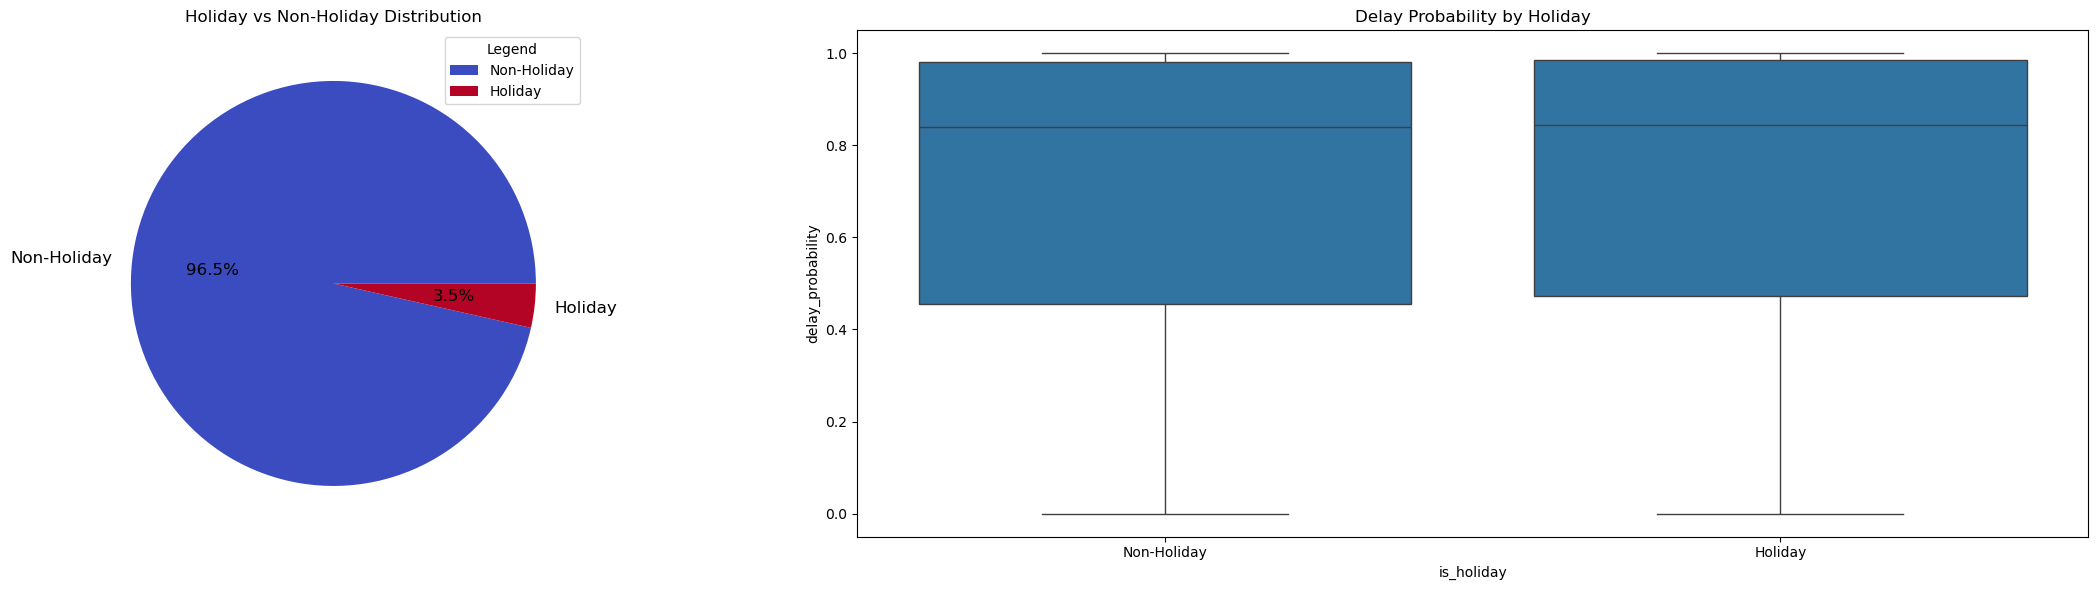

In [229]:
# Đánh giá liệu có ý nghĩa tương quan nào giữa ngày lễ với xác suất đơn hàng bị delay không
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

df['is_holiday'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    labels=['Non-Holiday', 'Holiday'], 
    colors=colors, 
    textprops={'color': 'black', 'size': 12}, 
    ax=axes[0]
)
axes[0].set_ylabel('')
axes[0].set_title("Holiday vs Non-Holiday Distribution")
axes[0].legend(['Non-Holiday', 'Holiday'], title="Legend", loc="upper right")

sns.boxplot(x='is_holiday', y='delay_probability', data=df, ax=axes[1])
axes[1].set_title('Delay Probability by Holiday')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Non-Holiday', 'Holiday'])

plt.tight_layout()
plt.show()

**Brief conclusion:** There does not appear to be any relationship between the timestamp and the delay probability.

### Bivariate Analysis


The correlation analysis should typically be performed before any other data preprocessing steps, such as balancing or scaling the data. This is because the correlation analysis is used to identify relationships between variables in the dataset, which can then be used to guide the selection of features and the development of the predictive model.

Performing the correlation analysis after scaling or balancing the data may result in a distorted view of the relationships between variables, as these preprocessing steps can change the distribution of the data. Therefore, it is generally recommended to perform the correlation analysis before any other data preprocessing steps.

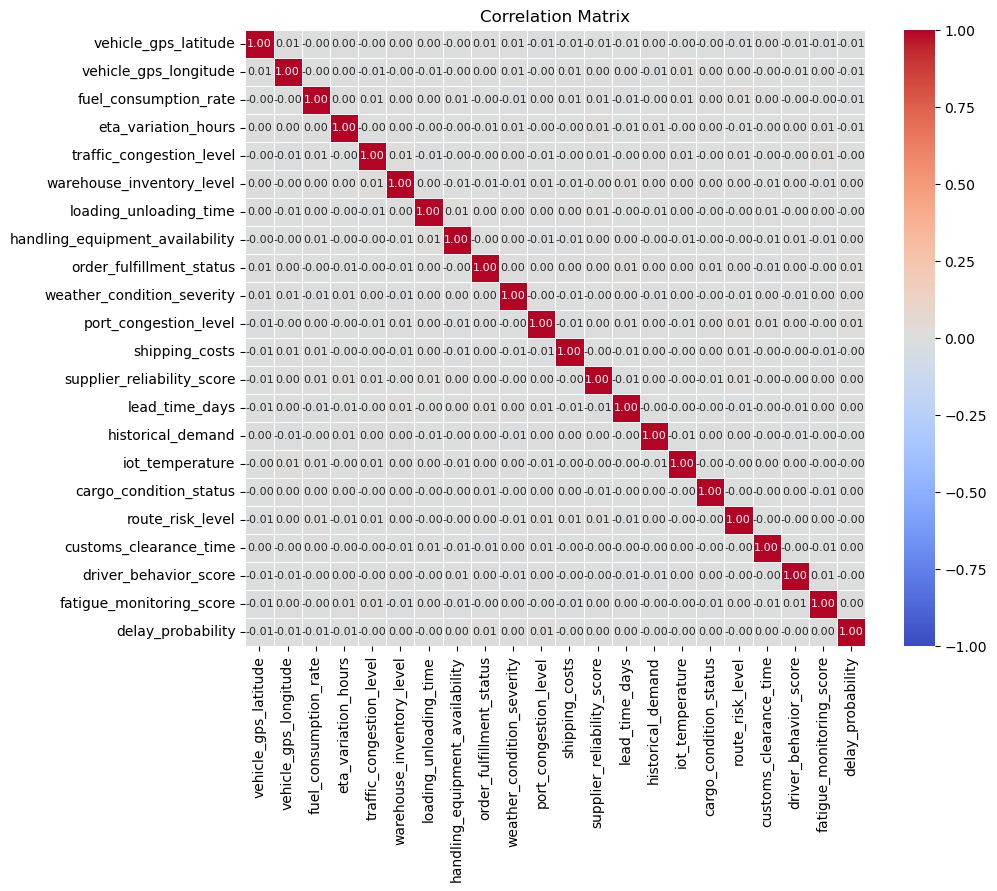

In [242]:
# Đánh giá tương quan giữa các biến đầu vào với nhau và với biến phụ thuộc

corr = float_variables_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1, annot_kws={'size': 8})
plt.title('Correlation Matrix')
plt.show()

In [43]:
corr['delay_probability'].sort_values()

fuel_consumption_rate             -0.013655
eta_variation_hours               -0.006897
vehicle_gps_latitude              -0.006185
vehicle_gps_longitude             -0.005691
driver_behavior_score             -0.003919
traffic_congestion_level          -0.003790
route_risk_level                  -0.003407
historical_demand                 -0.002907
iot_temperature                   -0.001139
loading_unloading_time            -0.000706
shipping_costs                    -0.000280
fatigue_monitoring_score           0.001070
lead_time_days                     0.001083
weather_condition_severity         0.001503
supplier_reliability_score         0.001890
handling_equipment_availability    0.002690
cargo_condition_status             0.002910
warehouse_inventory_level          0.004686
customs_clearance_time             0.004896
port_congestion_level              0.008972
order_fulfillment_status           0.009730
delay_probability                  1.000000
Name: delay_probability, dtype: 

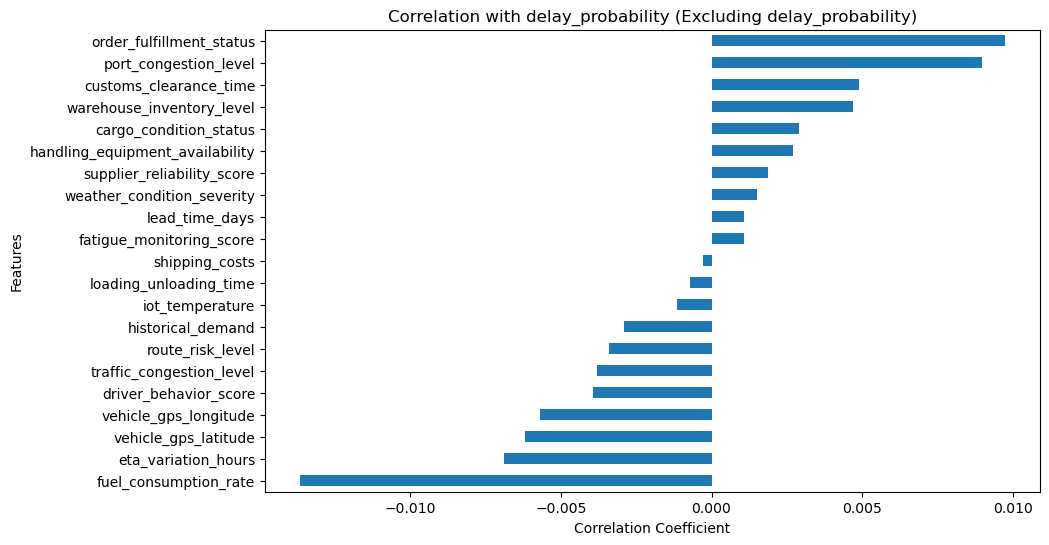

In [44]:
plt.figure(figsize=(10, 6))
corr['delay_probability'].drop('delay_probability').sort_values().plot(kind='barh')
plt.title('Correlation with delay_probability (Excluding delay_probability)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [266]:
from scipy.stats import pearsonr

def pearson_r_python(list1, list2):
    correlation, p_value = pearsonr(list1, list2)
    return correlation, p_value

results = []
for column in float_variables_df.columns:
    correlation, p_value = pearson_r_python(float_variables_df[column], df['delay_probability'])
    results.append([column, correlation, p_value])
results_df = pd.DataFrame(results, columns=['Column', 'Correlation', 'P-value'])

results_df.sort_values(by='P-value')

Column  Correlation  P-value
21                delay_probability       1.0000   0.0000
2             fuel_consumption_rate      -0.0137   0.0145
8          order_fulfillment_status       0.0097   0.0815
10            port_congestion_level       0.0090   0.1081
3               eta_variation_hours      -0.0069   0.2169
0              vehicle_gps_latitude      -0.0062   0.2681
1             vehicle_gps_longitude      -0.0057   0.3082
18           customs_clearance_time       0.0049   0.3807
5         warehouse_inventory_level       0.0047   0.4014
19            driver_behavior_score      -0.0039   0.4829
4          traffic_congestion_level      -0.0038   0.4973
17                 route_risk_level      -0.0034   0.5418
16           cargo_condition_status       0.0029   0.6023
14                historical_demand      -0.0029   0.6027
7   handling_equipment_availability       0.0027   0.6300
12       supplier_reliability_score       0.0019   0.7350
9        weather_condition_severity       0.0015   0.7878
15                  iot_temperature      -0.0011   0.8384
13                   lead_time_days       0.0011   0.8463
20         fatigue_monitoring_score       0.0011   0.8481
6            loading_unloading_time      -0.0007   0.8994
11                   shipping_costs      -0.0003   0.9600

**Brief conclusion:**
There is a very weak negative linear relationship between fuel_consumption_rate and delay_probability. The relationship is statistically significant (since the p-value is below 0.05), but the correlation is so small that its practical impact is likely negligible. The rest, the correlation values are very close to 0 and p-value is > 0.05, suggesting that there is virtually no significant linear relationship between the variables.

There is non-linear correlation models time to shine.

## Feature Enginerring

In [20]:
percentage_zeros = df[positive_skew_columns].apply(lambda x: (x == 0).mean() * 100)
percentage_ones = df[positive_skew_columns].apply(lambda x: (x == 1).mean() * 100)
percentage_negatives = df[positive_skew_columns].apply(lambda x: (x < 0).mean() * 100)

percentage_values_df = pd.DataFrame({
    'Percentage of 0': percentage_zeros,
    'Percentage of 1': percentage_ones,
    'Percentage of Negative Values': percentage_negatives
})

percentage_values_df

Percentage of 0  Percentage of 1  \
vehicle_gps_latitude                         0.0         0.000000   
fuel_consumption_rate                        0.0         0.000000   
traffic_congestion_level                     0.0         0.000000   
warehouse_inventory_level                    0.0         0.000000   
loading_unloading_time                       0.0         0.000000   
handling_equipment_availability              0.0         0.000000   
weather_condition_severity                   0.0         0.000000   
shipping_costs                               0.0         0.000000   
lead_time_days                               0.0         0.003119   
iot_temperature                              0.0         0.000000   
cargo_condition_status                       0.0         0.000000   
customs_clearance_time                       0.0         0.000000   
driver_behavior_score                        0.0         0.000000   

                                 Percentage of Negative Values  
vehicle_gps_latitude                                  0.000000  
fuel_consumption_rate                                 0.000000  
traffic_congestion_level                              0.000000  
warehouse_inventory_level                             0.000000  
loading_unloading_time                                0.000000  
handling_equipment_availability                       0.000000  
weather_condition_severity                            0.000000  
shipping_costs                                        0.000000  
lead_time_days                                        0.000000  
iot_temperature                                      68.039919  
cargo_condition_status                                0.000000  
customs_clearance_time                                0.000000  
driver_behavior_score                                 0.000000

With non-linear transformation, there are two types of available transformations in scikit learn: quantile transforms and power transforms. Both quantile and power transforms are based on monotonic transformations of the features and thus preserve the rank of the values along each feature.

Besides, as analyzed above, the input features have both positive and negative skew. On the other hand, the data does not contain 0 values, but it has 1 and negative values, so it is recommended to use Power Transformation to handle both positive and negative values.

Reference: https://scikit-learn.org/stable/modules/preprocessing.html#non-linear-transformation

### Power Transformer 

### Standard Scaler

Standardising is important when we compare different attributes that have very different units. Attributes that do not have similar scale will contribute differently to the model and may end up creating a bias. Transforming the data into comparable scales will prevent this issue from happening.

In [22]:
from sklearn.preprocessing import StandardScaler

standard_scaler_df = float_variables_df.copy()

X_standard_scaler = standard_scaler_df.drop(columns=['delay_probability'])

scaler = StandardScaler()
X_standard_scalered = scaler.fit_transform(X_standard_scaler)

standard_scalered_df = pd.DataFrame(X_standard_scalered, columns=X_standard_scaler.columns)

Using the Standard scaler on these distributions shifted the mean to 0, but didn’t really change the center (skewness) of the data. This is because the outliers in this dataset have an impact on the feature mean and standard deviation used to scale the features. Therefore, no need to check after-transformed distribution.

### Power Transformer

Power Transformer automates the decision of square root/cube root/log transformation by introducing a parameter lambda and finds the best value of lambda based on Box-Cox transformation or Yeo-Johnson transformation.

In [24]:
from sklearn.preprocessing import PowerTransformer

X_power_transformer = standard_scalered_df

pt = PowerTransformer(method='yeo-johnson')
X_power_transformerd = pt.fit_transform(X_power_transformer)

power_transformerd_df = pd.DataFrame(X_power_transformerd, columns=X_power_transformer.columns)

In [26]:
skewness_after_v2 = power_transformerd_df.skew().sort_values(ascending=False)
print("Skewness After PowerTransformation:")
print(skewness_after_v2)

Skewness After PowerTransformation:
iot_temperature                    0.551297
fuel_consumption_rate              0.550811
cargo_condition_status             0.303695
warehouse_inventory_level          0.301736
handling_equipment_availability    0.300321
lead_time_days                     0.292456
loading_unloading_time             0.137600
shipping_costs                     0.137356
customs_clearance_time             0.136543
vehicle_gps_latitude               0.133872
weather_condition_severity         0.003280
traffic_congestion_level           0.002494
driver_behavior_score              0.001147
supplier_reliability_score        -0.002840
historical_demand                 -0.132602
vehicle_gps_longitude             -0.132843
order_fulfillment_status          -0.136023
fatigue_monitoring_score          -0.137626
port_congestion_level             -0.297038
route_risk_level                  -0.299419
eta_variation_hours               -0.301653
dtype: float64


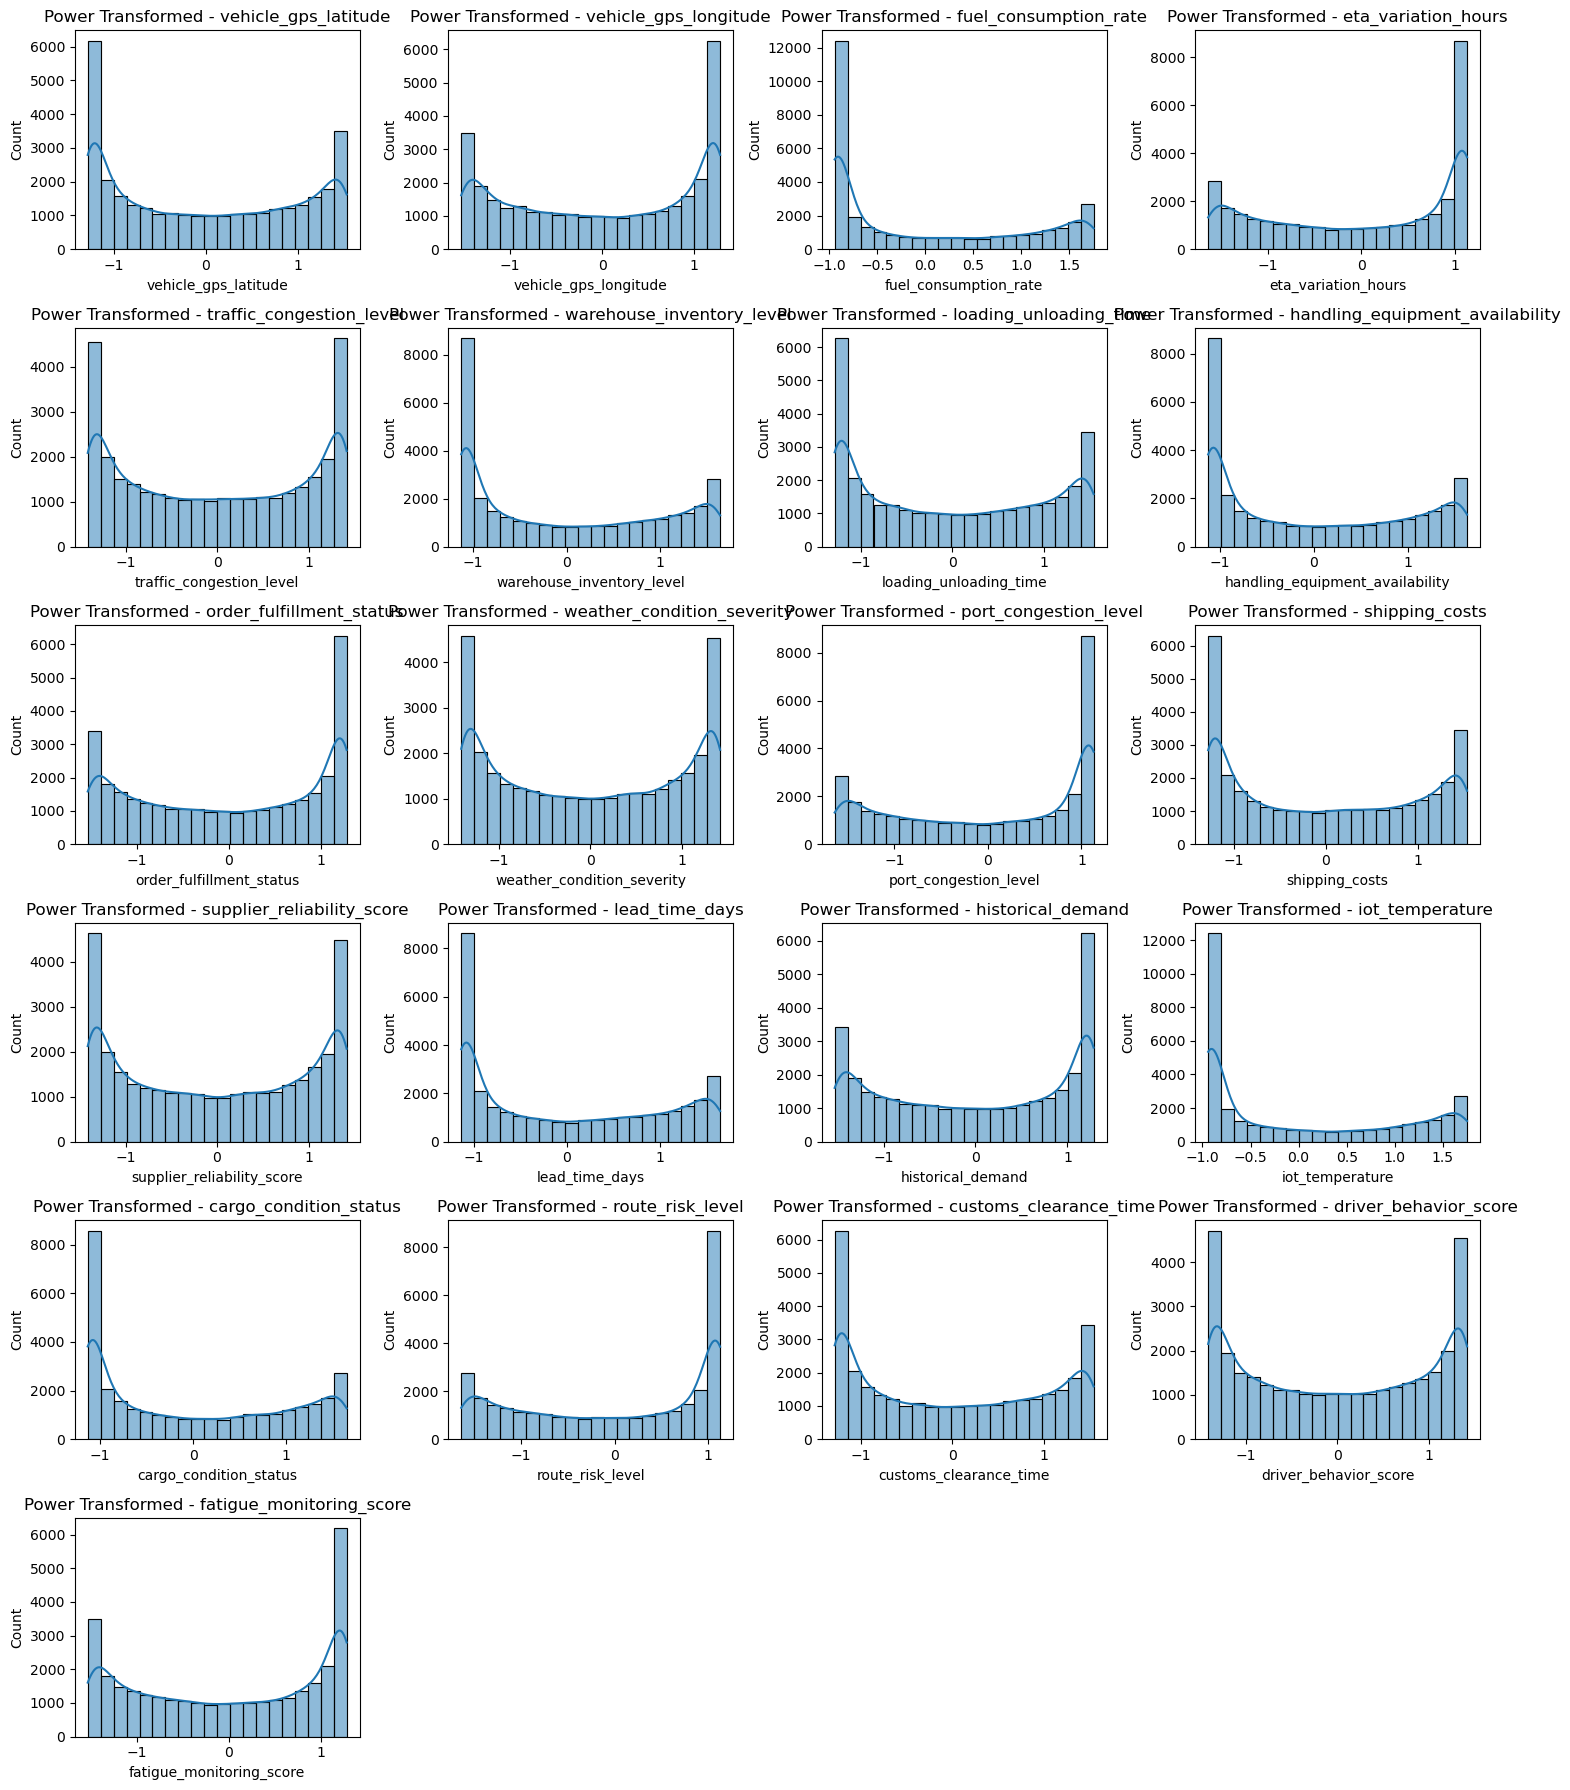

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

In [21]:
num_features = len(power_transformerd_df.columns)
num_cols = 4
num_rows = np.ceil(num_features / num_cols).astype(int)

plt.figure(figsize=(15, num_rows * 3))
for i, column in enumerate(power_transformerd_df.columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(power_transformerd_df[column], kde=True, bins=20)
    plt.title(f'Power Transformed - {column}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 12))

### Quantile Transformer

An estimation of the CDF distribution of the feature is computed and used to map the original values into a uniform distribution (in other words, frequent values are spread out into uniform distribution) or normal distribution (parameter specified in function). The obtained values is mapped to the desired output distribution using the associated quantile function

In [469]:
from sklearn.preprocessing import QuantileTransformer

X_quantile_transformer = standard_scalered_df

qt = QuantileTransformer(output_distribution='normal')
X_quantile_transformered = qt.fit_transform(X_quantile_transformer)
quantile_transformered_df = pd.DataFrame(X_quantile_transformered, columns=X_quantile_transformer.columns)

quantile_transformered_df.head()

vehicle_gps_latitude  vehicle_gps_longitude  fuel_consumption_rate  eta_variation_hours  traffic_congestion_level  warehouse_inventory_level  loading_unloading_time  handling_equipment_availability  order_fulfillment_status  weather_condition_severity  port_congestion_level  shipping_costs  supplier_reliability_score  lead_time_days  historical_demand  iot_temperature  cargo_condition_status  route_risk_level  customs_clearance_time  driver_behavior_score  fatigue_monitoring_score
0                0.3363                 0.3830                -0.3354               1.4595                    0.1505                     2.0903                  1.8643                           0.5491                    0.1500                     -0.2382                -0.7399          0.1525                      1.4337         -0.2314            -2.8642           0.4894                  1.1128           -1.3701                 -1.8424                -1.1794                    0.9927
1               -0.2975                -1.3192                -0.3915              -0.7325                   -0.6424                     0.4576                 -0.4459                           0.7698                   -0.8754                     -0.4665                -0.2915          0.4760                     -0.0631          1.2235            -0.2454          -0.4637                 -0.1872            0.4556                 -0.4903                -0.5263                    0.5800
2               -1.6729                 0.4928                -0.4135               0.9976                    0.7600                     1.2387                  0.9127                           1.1320                   -0.9847                     -1.2631                 0.4411         -0.6459                      0.1480          1.6178            -0.9595           0.1289                  0.2134           -0.3639                 -0.5058                -0.3941                   -0.4599
3                0.0170                 1.3723                 0.5089              -0.2388                   -1.7563                    -1.3381                 -1.2647                          -0.8516                    0.2611                      0.1742                 0.1296         -1.3267                      0.4045          0.0947            -0.7368           0.4584                  1.3935           -1.6390                  1.2633                -0.2211                    0.5260
4               -2.1534                 1.9155                -1.3650              -0.2101                    0.5558                     1.5296                  0.6318                          -0.6383                   -1.3610                      1.0837                -2.2671          1.6116                     -0.1194          1.5684            -0.8231           0.5555                  0.2294            0.1251                  0.5632                -1.3549                   -0.7060

In [444]:
skewness_after_v1 = quantile_transformered_df.skew().sort_values(ascending=False)
print("Skewness After Quantile Transformation:")
print(skewness_after_v1)

Skewness After Quantile Transformation:
delay_probability                  0.5094
route_risk_level                   0.4607
port_congestion_level              0.4199
eta_variation_hours                0.4165
historical_demand                  0.0762
vehicle_gps_longitude              0.0627
supplier_reliability_score         0.0350
order_fulfillment_status           0.0327
fatigue_monitoring_score           0.0089
traffic_congestion_level           0.0088
weather_condition_severity        -0.0043
shipping_costs                    -0.0274
driver_behavior_score             -0.0425
vehicle_gps_latitude              -0.0444
customs_clearance_time            -0.0645
loading_unloading_time            -0.0688
handling_equipment_availability   -0.4132
lead_time_days                    -0.4313
cargo_condition_status            -0.4542
warehouse_inventory_level         -0.4782
iot_temperature                   -1.5642
fuel_consumption_rate             -1.5697
dtype: float64


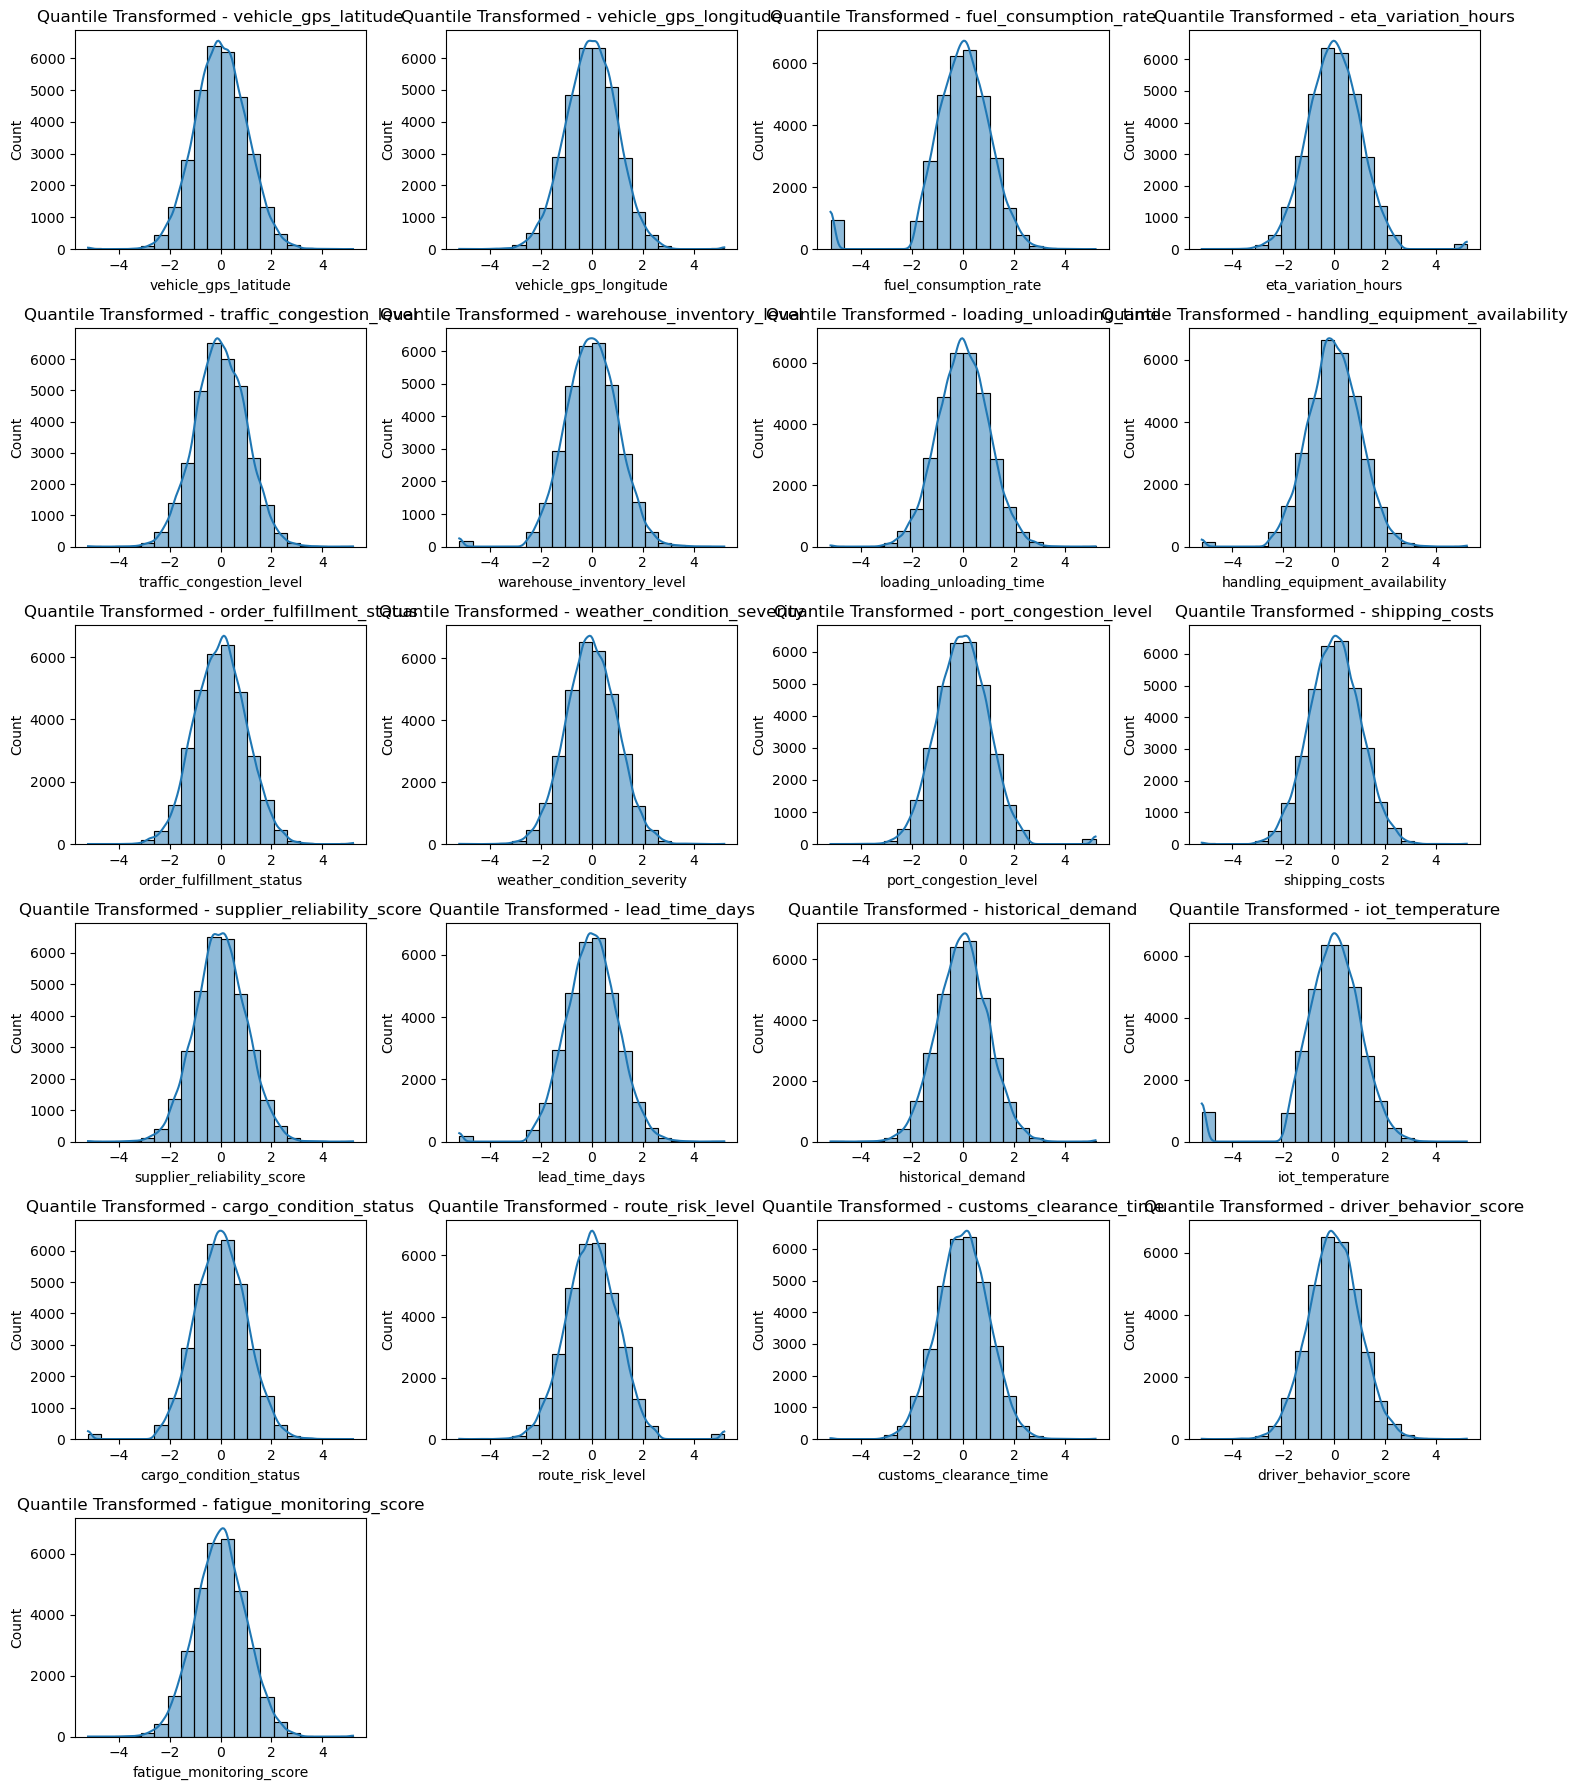

<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

In [472]:
num_features = len(quantile_transformered_df.columns)
num_cols = 4
num_rows = np.ceil(num_features / num_cols).astype(int)

plt.figure(figsize=(15, num_rows * 3))
for i, column in enumerate(quantile_transformered_df.columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(quantile_transformered_df[column], kde=True, bins=20)
    plt.title(f'Quantile Transformed - {column}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 12))

**Brief conclusion:** Due to the drawback that Quantile Transformation can alter the original distribution characteristics of the data, Power Transformation is chosen instead. This method aims to make the data more normally distributed and reduce skewness. By transforming the data, it enhances the model's performance, as the data becomes more symmetric and normally distributed. Additionally, Power Transformation helps stabilize the variance across the feature range, allowing the model to learn more effectively without being influenced by varying scales or outliers.

## Splitting the data into train and test

These are some commonly used splitting strategies:

- Train-Test Split: Shuffling the data randomly and dividing into training and testing blocks
- Stratified Split: As we said the testing data distribution should match as close as possible to training distribution, the data should be split in such a manner that if training data contains 80% of 1 labels and 20% of 0 labels, testing data contains labels in similar proportions.
- Cross-Validation: Splitting your data once and getting high (low)-performance metrics can be a fluke. Your data was splitted in such a random sense that got you a high accuracy or a poor accuracy and so your model performance can be over/under-estimated with checking on a single split. Plus you are not looking at complete available data (you are using only 80% of data for training when you can use 100%). So you split data into say 5 blocks, train on 4 blocks and test on left block, and you do this 5 times. This is called K-Fold Cross-Validation.
- Stratified K-Fold CV: Combining 2 and 3, making sure that the 1 test block and 4 train blocks contain the same data distribution. This basically means that every (1/K) block contains the same data distribution.
- ShuffleSplit: Sample train and test sets for given number of iterations. Unlike Cross-Validation, wherein you shuffle the data once in start before making training and testing folds, in ShuffleSplit, you shuffle for every iteration and make train and test folds so there is a possibility that a particular example never went into testing (or training) fold. Another advantage is that you can specify sizes of training and testing sets, which means you have the option to only use a part of data for training and testing purposes unlike Train-Test Split or Cross Validation which make use of complete data.
- Stratified Shuffle Split: Combining 5. and 2. - ShuffleSplit with Stratification i.e. sampling training and testing sets keeping class distribution in mind.

Reference: https://www.kaggle.com/discussions/general/303076n mind.

In [28]:
X = power_transformerd_df[float_feature_variables]
y = df['delay_probability']

# Chia tệp dữ liệu thành 3 tệp: training, test và validation với tỷ lệ 70%, 15% và 15%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=100)

In [30]:
# Kiểm tra shape của 3 tệp
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((22445, 21), (4810, 21), (4810, 21), (22445,), (4810,), (4810,))

<Axes: xlabel='delay_probability', ylabel='Density'>

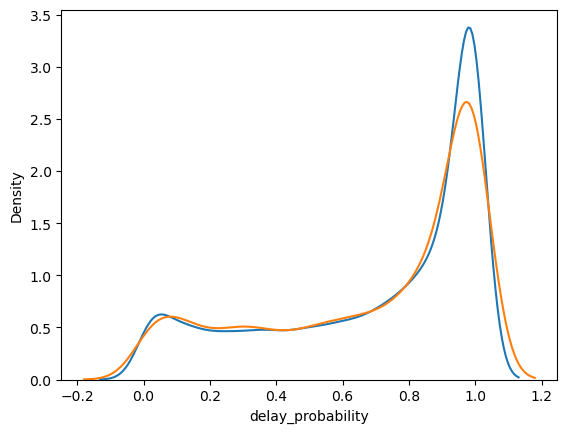

In [26]:
# Đánh giá phân bổ của biến phụ thuộc sau khi split dữ liệu
y_train_df = pd.DataFrame(y_train, columns=['delay_probability'])
y_test_df = pd.DataFrame(y_test, columns=['delay_probability'])

sns.kdeplot(data=y_train_df, x='delay_probability')
sns.kdeplot(data=y_test_df, x='delay_probability')

In [480]:
from scipy.stats import ks_2samp

#  KS statistic: a measure to compare empirical cumulative distribution functions (ECDFs) of two samples
stat, p_value = ks_2samp(y_train_df['delay_probability'], y_test_df['delay_probability'])

print(f"KS Statistic: {stat:.4f}")
print(f"P-Value: {p_value:.4f}")

if p_value < 0.05:
    print("The two distributions are significantly different.")
else:
    print("The two distributions are not significantly different.")

KS Statistic: 0.0155
P-Value: 0.2927
The two distributions are not significantly different.


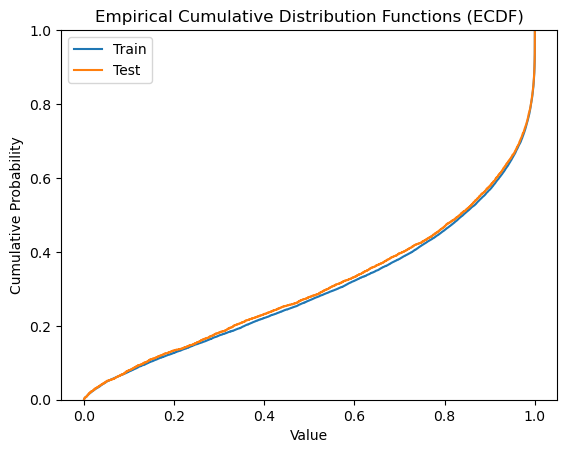

In [482]:
# Plot ECDFs
sns.ecdfplot(y_train_df['delay_probability'], label="Train")
sns.ecdfplot(y_test_df['delay_probability'], label="Test")
plt.title('Empirical Cumulative Distribution Functions (ECDF)')
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

## Feature selection

### Boruta

In [179]:
from boruta import BorutaPy
# Khởi tạo Boruta
feat_selector = BorutaPy(rf_model, n_estimators='auto', verbose=2, random_state=1, max_iter = 10) # số lần thử
feat_selector.fit(np.array(X_train), np.array(y_train))
feat_selector.support_
feat_selector.ranking_
feature_ranks = list(zip(X_train.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	0
Tentative: 	4
Rejected: 	17
Iteration: 	9 / 10
Confirmed: 	0
Tentative: 	4
Rejected: 	17


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	0
Tentative: 	0
Rejected: 	21
Feature: vehicle_gps_latitude      Rank: 9,  Keep: False
Feature: vehicle_gps_longitude     Rank: 11,  Keep: False
Feature: fuel_consumption_rate     Rank: 16,  Keep: False
Feature: eta_variation_hours       Rank: 2,  Keep: False
Feature: traffic_congestion_level  Rank: 4,  Keep: False
Feature: warehouse_inventory_level Rank: 4,  Keep: False
Feature: loadin

The output of Boruta categorizes features into three groups:

- Ranking 1: Confirmed features (These features carry some signals related to the target variable, so they should be retained.)
- Ranking 2: Tentative features (Boruta is uncertain about these features, and the decision is up to you.)
- Ranking 3 or higher: Rejected features (Features in this ranking are considered noise.)

The predicted features have a ranking greater than 3, so they were all eliminated. 

## Regression Modeling

### Polynomial Regression

In the cases with non-linear data, we can try to use polynomial to simulate the relationship between the output(prediction) and input(features).

In [64]:
# Khởi tạo model base
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet

poly_features = PolynomialFeatures()
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

ridge_model = Ridge()
ridge_model.fit(X_train_poly, y_train)
y_pred_ridge = ridge_model.predict(X_test_poly)

ridge_mse = mean_squared_error(y_test, y_pred_ridge)
print(f"Ridge MSE: {ridge_mse:.4f}")

Ridge MSE: 0.1081


In [66]:
lasso_model = Lasso()
lasso_model.fit(X_train_poly, y_train)
y_pred_lasso = lasso_model.predict(X_test_poly)

lasso_mse = mean_squared_error(y_test, y_pred_lasso)
print(f"Lasso MSE: {lasso_mse:.4f}")

Lasso MSE: 0.1067


In [68]:
elastic_model = ElasticNet()
elastic_model.fit(X_train_poly, y_train)
y_pred_elastic = elastic_model.predict(X_test_poly)

elastic_mse = mean_squared_error(y_test, y_pred_elastic)
print(f"Elastic Net MSE: {elastic_mse:.4f}")

Elastic Net MSE: 0.1067


Text(0, 0.5, 'Predicted Probability')

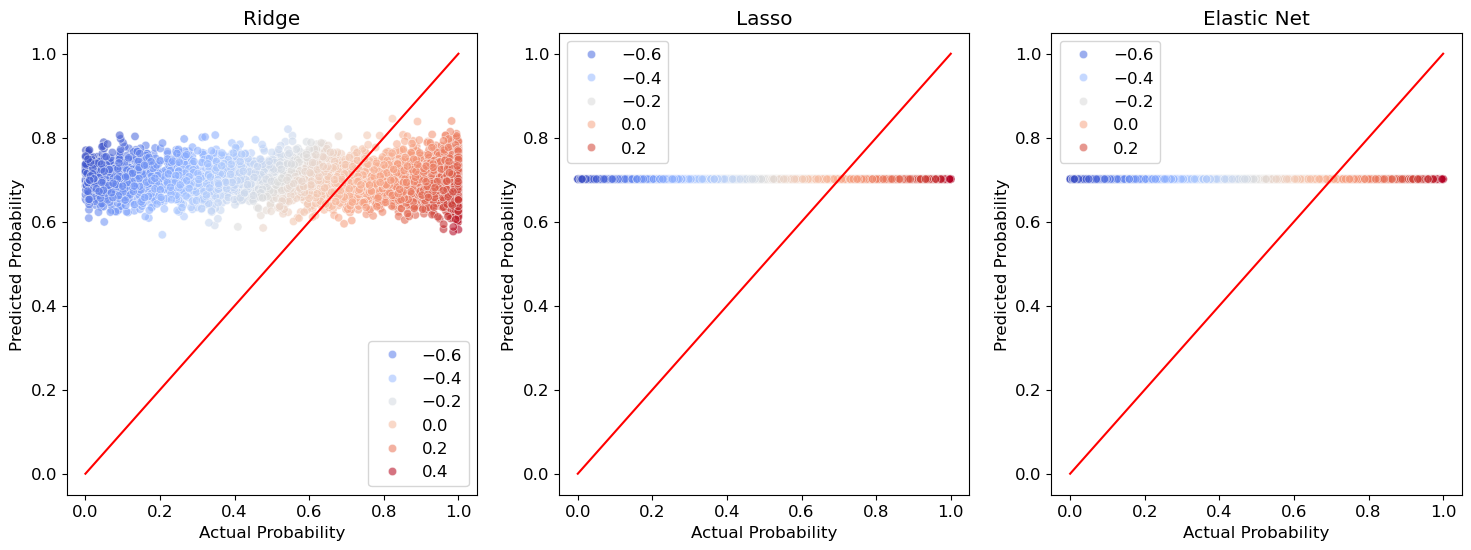

In [151]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_ridge = (y_test - y_pred_ridge)
residuals_lasso = (y_test - y_pred_lasso)
residuals_elastic = (y_test - y_pred_elastic)

# Trực quan
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
scatter = sns.scatterplot(ax=axes[0], x=y_test, y=y_pred_ridge, hue=residuals_ridge, palette='coolwarm', alpha=0.6)
sns.lineplot(ax=axes[0], x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')
axes[0].set_title('Ridge')
axes[0].set_xlabel('Actual Probability')
axes[0].set_ylabel('Predicted Probability')

scatter = sns.scatterplot(ax=axes[1], x=y_test, y=y_pred_lasso, hue=residuals_lasso, palette='coolwarm', alpha=0.6)
sns.lineplot(ax=axes[1], x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')
axes[1].set_title('Lasso')
axes[1].set_xlabel('Actual Probability')
axes[1].set_ylabel('Predicted Probability')

scatter = sns.scatterplot(ax=axes[2], x=y_test, y=y_pred_elastic, hue=residuals_elastic, palette='coolwarm', alpha=0.6)
sns.lineplot(ax=axes[2], x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')
axes[2].set_title('Elastic Net')
axes[2].set_xlabel('Actual Probability')
axes[2].set_ylabel('Predicted Probability')

In [135]:
# Tuning
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

# Prepare a range of polynomial degrees to try
degrees = range(2, 4)
n_alphas = 100
alphas = 1/np.logspace(1, -2, n_alphas) # Regularization strengths for Ridge/Lasso
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    
    # Transform features
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    for alpha in alphas:
        # Ridge Regression
        ridge_model = Ridge(alpha=alpha, fit_intercept=False)
        ridge_scores = cross_val_score(ridge_model, X_train_poly, y_train, cv=cv, scoring='neg_mean_squared_error', verbose=1)
        ridge_mse = -ridge_scores.mean()
        
        # Lasso Regression
        lasso_model = Lasso(alpha=alpha, max_iter=10000)
        lasso_scores = cross_val_score(lasso_model, X_train_poly, y_train, cv=cv, scoring='neg_mean_squared_error', verbose=1)
        lasso_mse = -lasso_scores.mean() 
        
        # ElasticNet Regression
        elasticnet_model = ElasticNet(alpha=alpha, l1_ratio= 0.5)
        elasticnet_scores = cross_val_score(elasticnet_model, X_train_poly, y_train, cv=cv, scoring='neg_mean_squared_error', verbose=1)
        elasticnet_mse = -elasticnet_scores.mean() 

        # Save the results
        results.append((degree, alpha, 'Ridge', ridge_mse))
        results.append((degree, alpha, 'Lasso', lasso_mse))
        results.append((degree, alpha, 'ElasticNet', elasticnet_mse))

# Find the best model
best_poly_model = min(results, key=lambda x: x[3])  # Lowest MSE
print(f"Best model: Degree {best_poly_model[0]}, Alpha {best_poly_model[1]}, Model {best_poly_model[2]} with MSE: {best_poly_model[3]}")

Best model: Degree 2, Alpha 0.1, Model Lasso with MSE: 0.10458020439409732


Note: Regularization methods like Ridge regression (L2) and Lasso regression (L1) can be used to handle non-linear relationships by penalizing the magnitude of the coefficients in a regression model. This penalty discourages the model from fitting the noise in the data and can result in a more generalized model. Regularization is especially helpful when dealing with multicollinearity or when you have more predictors than observations.
  
- Lasso Regression: The main purpose of Lasso regression is to perform feature selection by encouraging sparsity in the coefficient values. This means that it tends to shrink less important features towards zero, effectively excluding them from the model. Lasso regression can be helpful when dealing with high-dimensional datasets, where there are many potentially irrelevant features. By reducing the number of features, Lasso regression simplifies the model and improves interpretability.
  + Performs L1 regularization, i.e., adds penalty equivalent to the absolute value of the magnitude of coefficients
  + Minimization objective = LS Obj + α * (sum of the absolute value of coefficients)

- Ridge Regression: Ridge regression aims to reduce the impact of highly correlated features by shrinking their coefficients towards zero while keeping them non-zero. Unlike Lasso regression, Ridge regression does not perform explicit feature selection, as it generally keeps all features in the model. Instead, it reduces the magnitude of coefficients and helps to mitigate the effects of multicollinearity. Ridge regression is useful when dealing with multicollinearity issues, where independent variables are highly correlated, as it stabilizes the model and improves its generalization performance.
  + Performs L2 regularization, i.e., adds penalty equivalent to the square of the magnitude of coefficients
  + Minimization objective = LS Obj + α * (sum of square of coefficients)

The choice between Lasso regression and Ridge regression depends on the specific problem and the characteristics of the dataset:
- If feature selection is a primary concern and you want to identify the most important predictors, Lasso regression is a suitable choice.
- If multicollinearity is a concern and you want to reduce the impact of correlated features, Ridge regression is a suitable choice.
- In some cases, a combination of Lasso and Ridge regression can be used, known as Elastic Net regression, to balance between feature selection and handling multicollinearity.

Reference:
- https://www.linkedin.com/advice/3/how-can-you-handle-non-linear-relationships-regression-rrile
- https://medium.com/@sujathamudadla1213/why-we-have-to-use-lasso-regression-and-ridge-regression-a8d74bf4716flerrile

In [156]:
# Predict
best_poly_transformation = PolynomialFeatures(degree=best_poly_model[0])
X_train_best_poly = best_poly_transformation.fit_transform(X_train)
X_test_best_poly = best_poly_transformation.transform(X_test)

best_lasso_model = Lasso(alpha=best_poly_model[1], max_iter=10000)

best_lasso_model.fit(X_train_best_poly, y_train)
y_pred_best_poly = best_lasso_model.predict(X_test_best_poly)

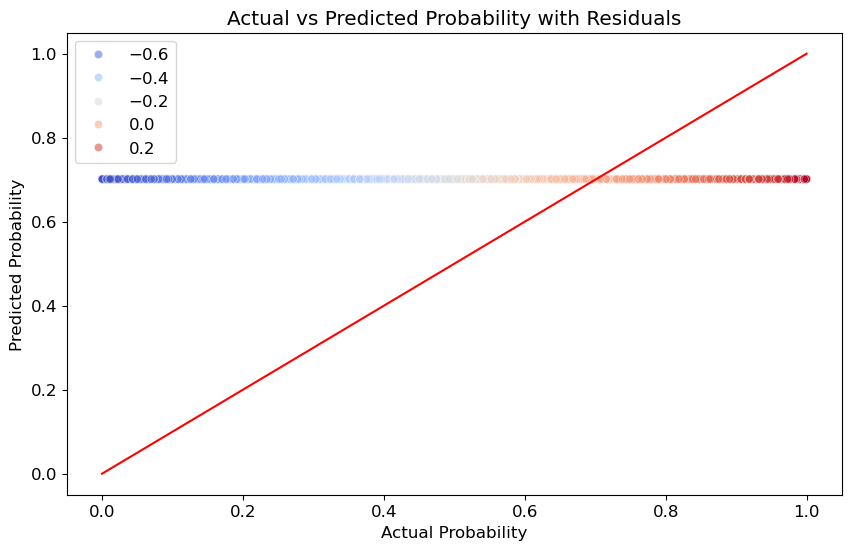

In [154]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_best_poly = (y_test - y_pred_best_poly)

# Trực quan
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=y_test, y=y_pred_best_poly, hue=residuals_best_poly, palette='coolwarm', alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')

plt.title('Actual vs Predicted Probability with Residuals')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.show()

### Decision Tree Regression

In general, decision trees are good at learning complex, non-linear relationships between the features and the target variable. They are non-parametric models that partition the feature space into regions that are separated by decision boundaries, based on the values of the features. They can easily capture interactions between features, and they don't require the data to be linearly separable. This makes them well-suited to handling a wide variety of data, including data with many features and complex relationships between the features and the target variable. 

In fact, tree-based algorithms are insensitive to the scale of the features since they are rule-based algorithms. A node in a decision tree splits by maximizing the information gain of a single feature and is not influenced by other features. Scaling this specific feature or scaling the others will not affect the information gain and homogeneity of the node. Hence, they are invariant to the scale of features and are robust to outliers.

In [158]:
# Khởi tạo model base
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=42)

tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

tree_mse = mean_squared_error(y_test, y_pred_tree)
print(f"Decision Tree MSE: {tree_mse:.4f}")

Decision Tree MSE: 0.2124


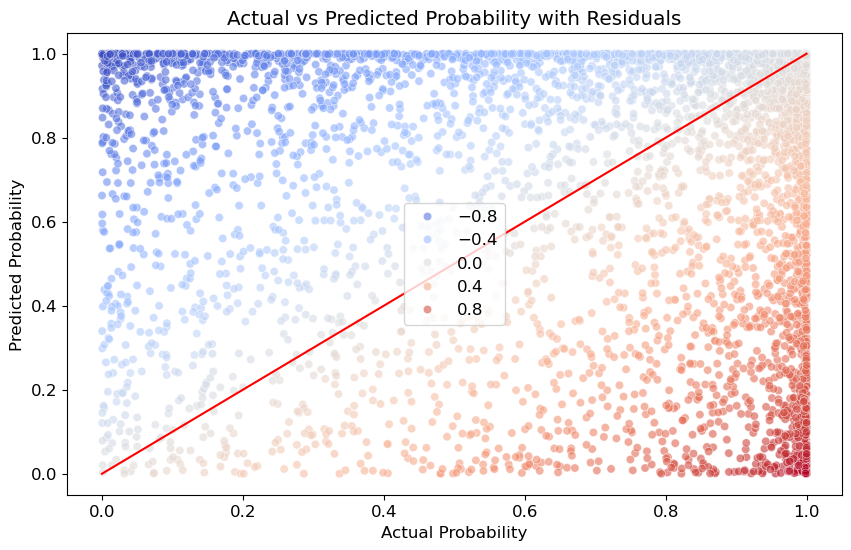

In [160]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_tree = (y_test - y_pred_tree)

# Trực quan
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=y_test, y=y_pred_tree, hue=residuals_tree, palette='coolwarm', alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')

plt.title('Actual vs Predicted Probability with Residuals')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.show()

In [60]:
# Độ sâu của model
print("Max Depth of Decision Tree:", tree_model.get_depth())

Max Depth of Decision Tree: 64


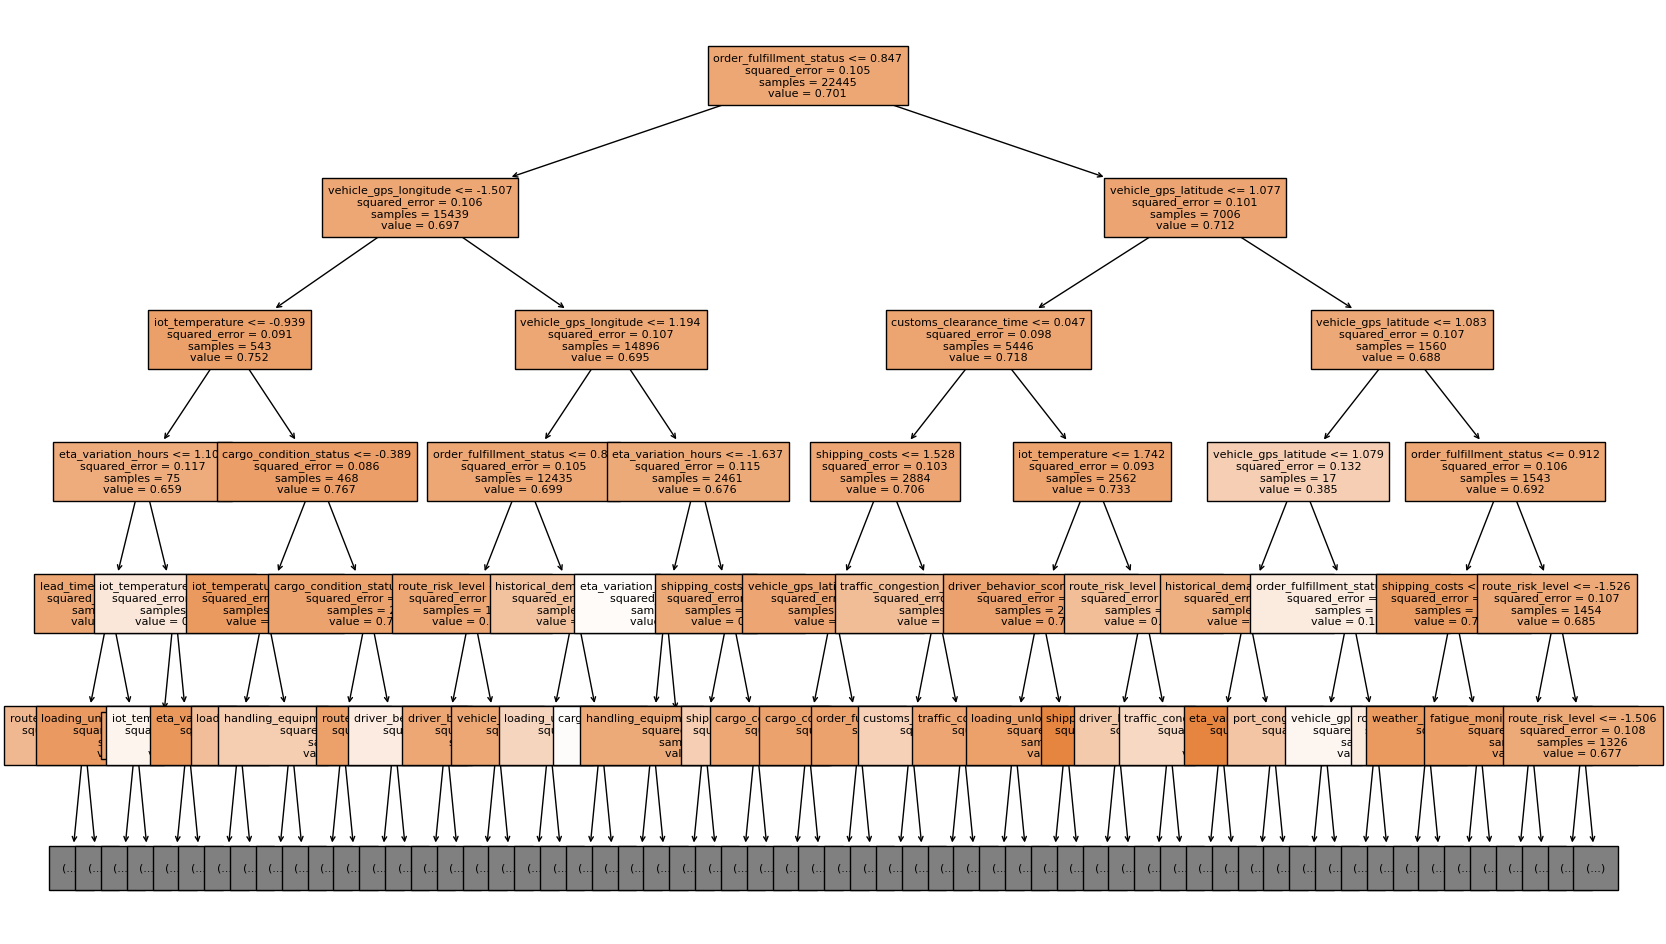

In [58]:
# Trực quan decision tree
from sklearn import tree
plt.figure(figsize=(20, 12))
tree.plot_tree(tree_model, max_depth=5, filled=True, feature_names=X_train.columns, fontsize=8)
plt.show()

In [103]:
# Feature Importance
tree_feature_importances = tree_model.feature_importances_

tree_feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': tree_feature_importances,
})

tree_feature_importances_df = tree_feature_importances_df.sort_values(by='Importance', ascending=False)

print(tree_feature_importances_df)

                            Feature  Importance
19            driver_behavior_score    0.055344
0              vehicle_gps_latitude    0.053999
5         warehouse_inventory_level    0.053515
10            port_congestion_level    0.052506
11                   shipping_costs    0.050900
20         fatigue_monitoring_score    0.050591
8          order_fulfillment_status    0.048473
6            loading_unloading_time    0.048352
14                historical_demand    0.047858
17                 route_risk_level    0.047766
9        weather_condition_severity    0.047703
13                   lead_time_days    0.046766
2             fuel_consumption_rate    0.045980
15                  iot_temperature    0.045386
7   handling_equipment_availability    0.045000
4          traffic_congestion_level    0.044944
3               eta_variation_hours    0.044527
18           customs_clearance_time    0.044239
1             vehicle_gps_longitude    0.044202
12       supplier_reliability_score    0

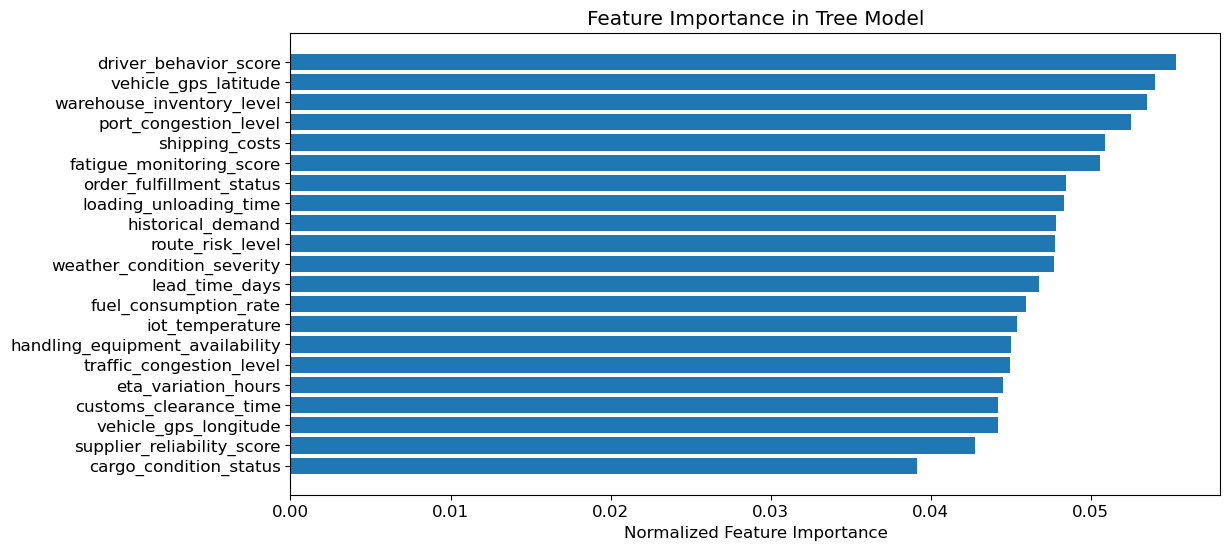

In [105]:
# Trực quan Feature Importance
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(12,6))

plt.barh(tree_feature_importances_df['Feature'], tree_feature_importances_df['Importance'])
plt.xlabel('Normalized Feature Importance')
plt.title('Feature Importance in Tree Model')
plt.gca().invert_yaxis()
plt.show()

Top 6 importance features in Decision Tree:
- driver_behavior_score
- vehicle_gps_latitude
- warehouse_inventory_level
- port_congestion_level
- shipping_costs 
- fatigue_monitoring_score

In [80]:
# Độ sâu của Decision Tree lớn, cần tiếp tục tuning để tránh overfitting
# Tuning
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid to search over
param_grid = {
    'max_depth': [3, 5, 10, 15, None],  # Max depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 5],    # Minimum number of samples required to be at a leaf node
    'max_features':[0.25,0.5,1.0] # Number of features to consider each time to make the split decision
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=param_grid,
    cv=5,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    refit='neg_mean_squared_error',  # Prioritizing MSE
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

best_dtree_reg = grid_search.best_estimator_ # Get the best estimator from the grid search
y_pred = best_dtree_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Get the best parameters and the corresponding MSE
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_

print(f"Best Decision Tree Parameters: {best_params}")
print(f"Best MSE: {best_mse}")

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Decision Tree Parameters: {'max_depth': 3, 'max_features': 0.25, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best MSE: 0.10491444419521405


In [86]:
# Predict
best_tree_model = grid_search.best_estimator_ 
y_pred_best_tree = best_tree_model.predict(X_test) 

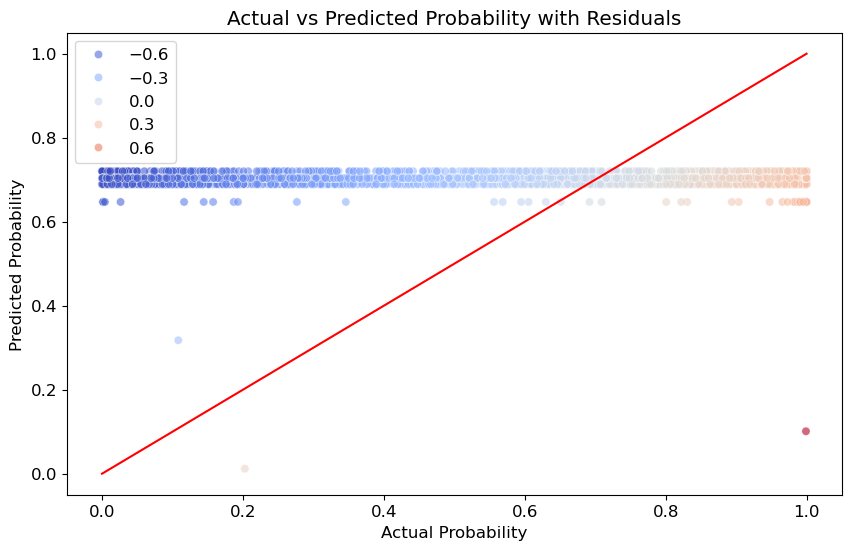

In [162]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_best_tree = (y_test - y_pred_best_tree)

# Trực quan
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=y_test, y=y_pred_best_tree, hue=residuals_best_tree, palette='coolwarm', alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')

plt.title('Actual vs Predicted Probability with Residuals')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.show()

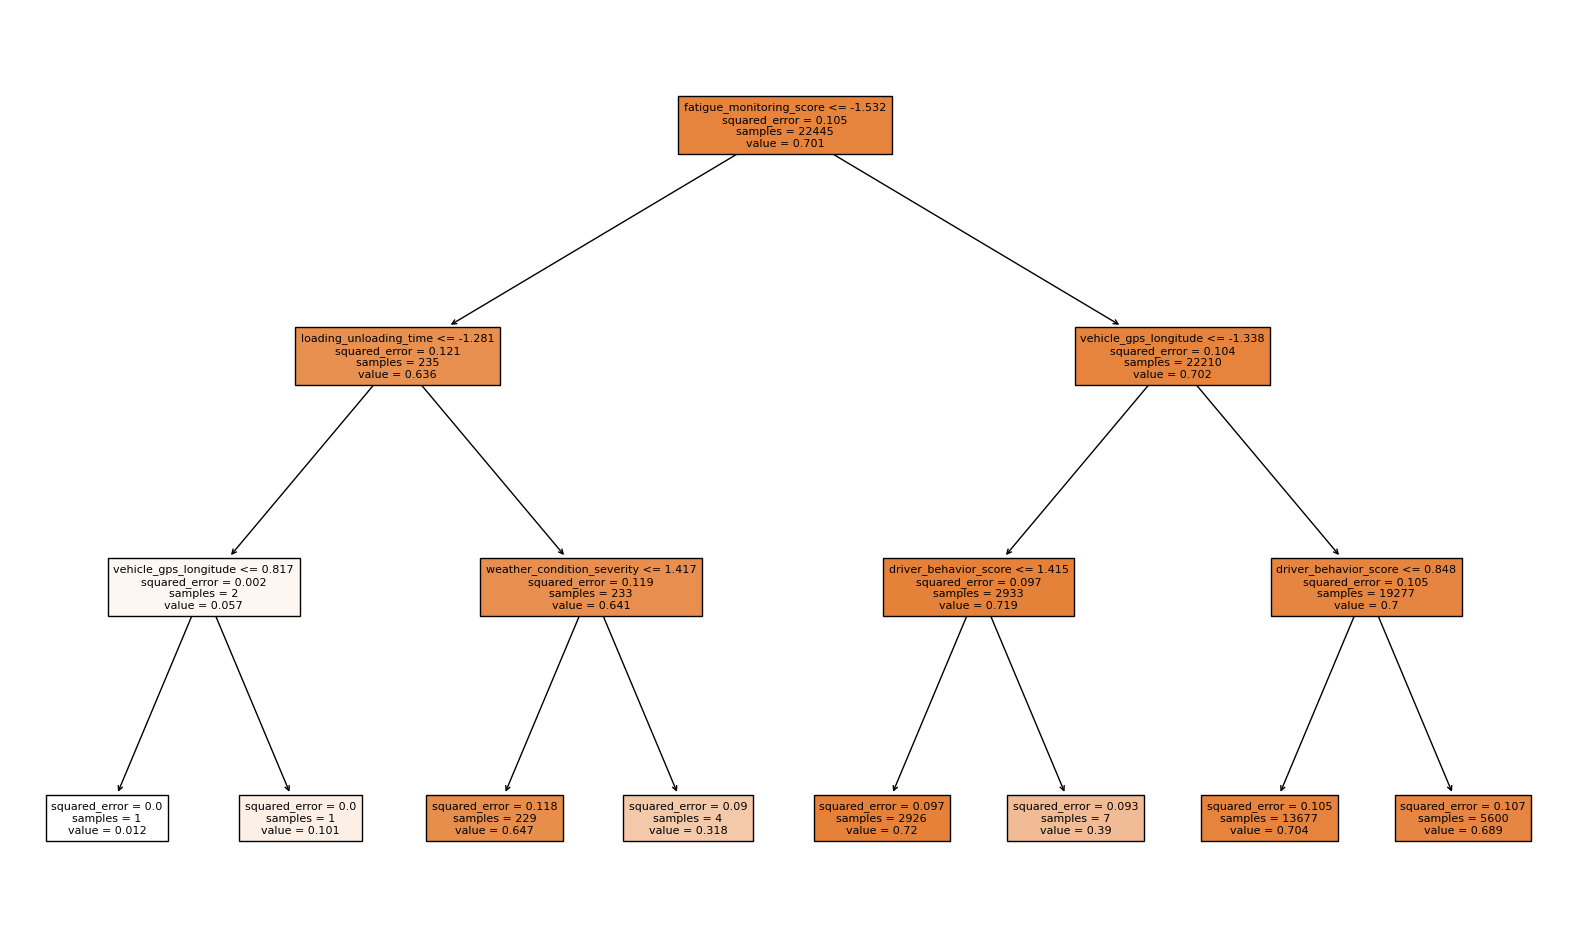

In [90]:
# Trực quan decision tree
from sklearn import tree
plt.figure(figsize=(20, 12))
tree.plot_tree(best_tree_model, max_depth=5, filled=True, feature_names=X_train.columns, fontsize=8)
plt.show()

In [92]:
# Feature Importance
best_tree_feature_importances = best_tree_model.feature_importances_

best_tree_feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_tree_feature_importances,
})

best_tree_feature_importances_df = best_tree_feature_importances_df.sort_values(by='Importance', ascending=False)

print(best_tree_feature_importances_df)

                            Feature  Importance
19            driver_behavior_score    0.334738
1             vehicle_gps_longitude    0.215257
20         fatigue_monitoring_score    0.214355
6            loading_unloading_time    0.144707
9        weather_condition_severity    0.090942
12       supplier_reliability_score    0.000000
18           customs_clearance_time    0.000000
17                 route_risk_level    0.000000
16           cargo_condition_status    0.000000
15                  iot_temperature    0.000000
14                historical_demand    0.000000
13                   lead_time_days    0.000000
0              vehicle_gps_latitude    0.000000
11                   shipping_costs    0.000000
8          order_fulfillment_status    0.000000
7   handling_equipment_availability    0.000000
5         warehouse_inventory_level    0.000000
4          traffic_congestion_level    0.000000
3               eta_variation_hours    0.000000
2             fuel_consumption_rate    0

Top 5 importance features in Decision Tree:
- driver_behavior_score
- vehicle_gps_latitude
- fatigue_monitoring_score
- loading_unloading_time
- weather_condition_severity

### Random Forest Regression

In [74]:
# Khởi tạo model base
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {rf_mse:.4f}")

Random Forest MSE: 0.1098


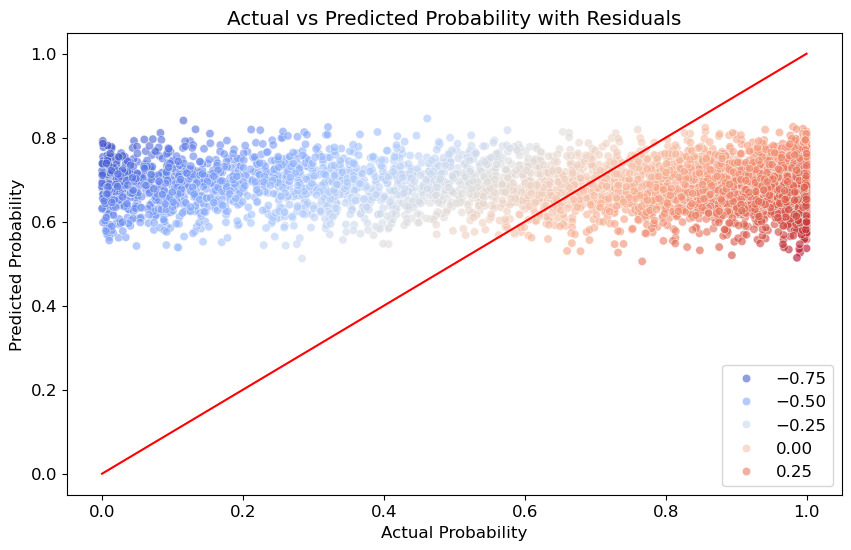

In [164]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_rf = (y_test - y_pred_rf)

# Trực quan
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=y_test, y=y_pred_rf, hue=residuals_rf, palette='coolwarm', alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')

plt.title('Actual vs Predicted Probability with Residuals')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.show()

In [150]:
# Feature Importance
rf_feature_importances = rf_model.feature_importances_

rf_feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_feature_importances,
})

rf_feature_importances_df = rf_feature_importances_df.sort_values(by='Importance', ascending=False)

print(rf_feature_importances_df)

                            Feature  Importance
3               eta_variation_hours    0.050256
20         fatigue_monitoring_score    0.048797
4          traffic_congestion_level    0.048548
8          order_fulfillment_status    0.048503
13                   lead_time_days    0.048353
12       supplier_reliability_score    0.048292
9        weather_condition_severity    0.048132
5         warehouse_inventory_level    0.048082
17                 route_risk_level    0.048026
11                   shipping_costs    0.047656
19            driver_behavior_score    0.047383
1             vehicle_gps_longitude    0.047297
2             fuel_consumption_rate    0.047263
10            port_congestion_level    0.047028
14                historical_demand    0.046919
18           customs_clearance_time    0.046820
7   handling_equipment_availability    0.046685
15                  iot_temperature    0.046632
0              vehicle_gps_latitude    0.046549
6            loading_unloading_time    0

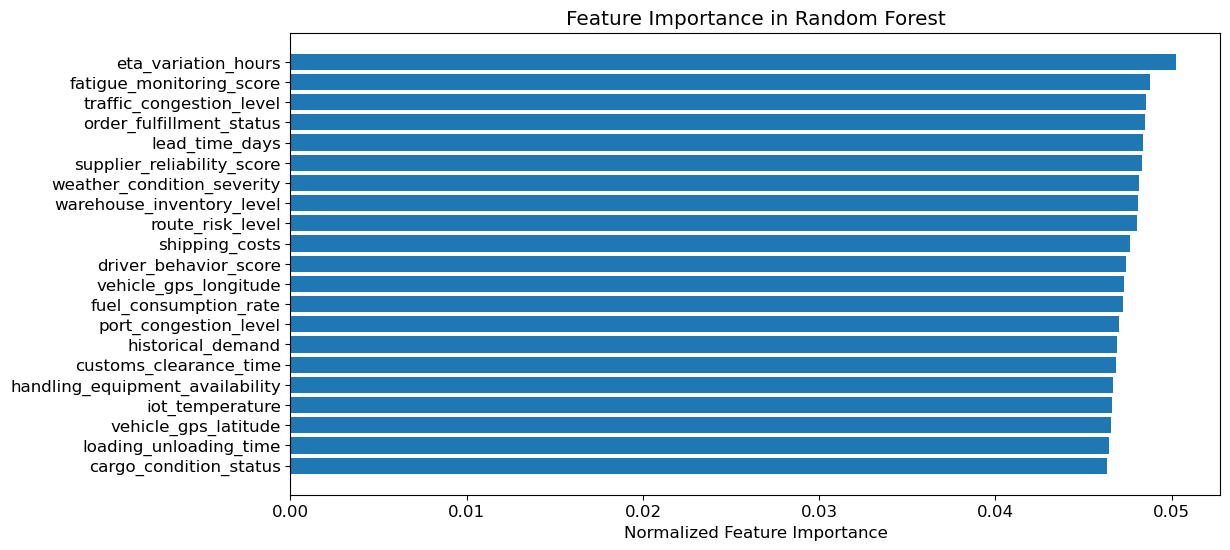

In [146]:
# Trực quan Feature Importance
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(12,6))

plt.barh(rf_feature_importances_df['Feature'], rf_feature_importances_df['Normalized Importance'])
plt.xlabel('Normalized Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

Top 6 importance features in Random Forest:

- eta_variation_hours
- fatigue_monitoring_score
- traffic_congestion_level
- order_fulfillment_status
- lead_time_days
- supplier_reliability_score

In [117]:
# Tuning

param_grid_rf = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [3, 5, 10, 15, None],    # Max depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 5],    # Minimum samples required to be at a leaf node
    'max_features': [0.25,0.5,1.0] # Number of features to consider each time to make the split decision
}

# Perform Grid Search with cross-validation
grid_search_rf = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid_rf, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and MSE from Grid Search
best_params_rf = grid_search_rf.best_params_
best_mse_rf = -grid_search_rf.best_score_

print(f"Best Random Forest Parameters: {best_params_rf}")
print(f"Best MSE on Training Data: {best_mse_rf}")

Best Random Forest Parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best MSE on Training Data: 0.10458817174820045


In [114]:
# Predict 
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

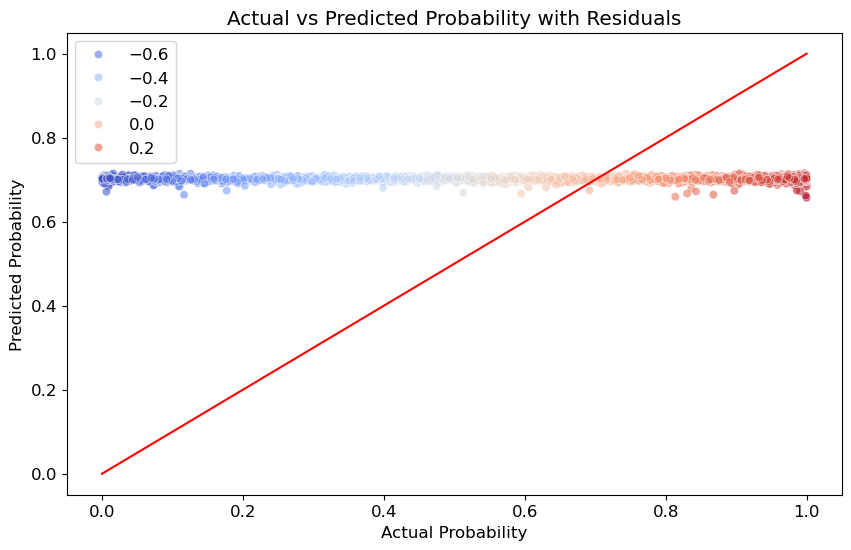

In [145]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_best_rf = (y_test - y_pred_best_rf)

# Trực quan
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=y_test, y=y_pred_best_rf, hue=residuals_best_rf, palette='coolwarm', alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')

plt.title('Actual vs Predicted Probability with Residuals')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.show()

### XGBoost Regression

In [75]:
# Khởi tạo model base
import xgboost as xgb

xgb_model = xgb.XGBRegressor(eval_metric='rmsle')

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

xgb_mse = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost Regression MSE: {xgb_mse:.4f}")

XGBoost Regression MSE: 0.1167


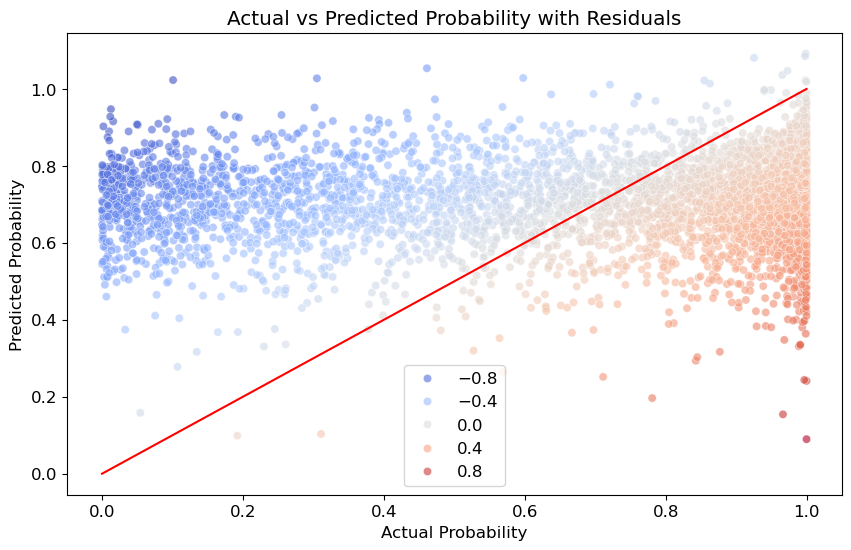

In [166]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_xgb = (y_test - y_pred_xgb)

# Trực quan
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=y_test, y=y_pred_xgb, hue=residuals_xgb, palette='coolwarm', alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')

plt.title('Actual vs Predicted Probability with Residuals')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.show()

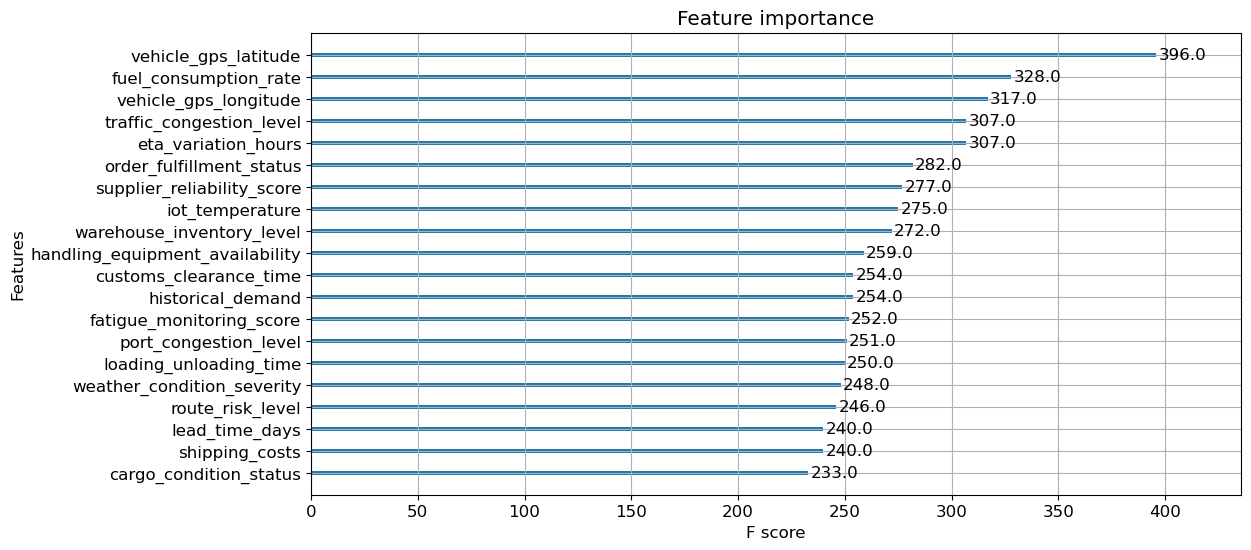

In [164]:
# Feature Importance 
from xgboost import plot_importance
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(xgb_model, max_num_features=20, ax=ax)
plt.show()

Top 6 importance features in XGBoost Regression:

- vehicle_gps_latitude
- fuel_consumption_rate
- vehicle_gps_longtitude
- traffic_congestion_level
- eta_variation_hours
- order_fulfillment_status

In [121]:
# Tuning
param_grid = {"max_depth":    [5, 10, 15], # Maximum depth of a tree
              "n_estimators": [500, 600, 700], # Number of gradient boosted trees. Equivalent to number of boosting rounds.
              "learning_rate": [0.01, 0.015]} # Boosting learning rate

grid_search_xgb = GridSearchCV(xgb_model, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ", grid_search_xgb.best_params_)

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}


In [125]:
# Predict
best_xgb_model=xgb.XGBRegressor(learning_rate = grid_search_xgb.best_params_["learning_rate"],
                                n_estimators  = grid_search_xgb.best_params_["n_estimators"],
                                max_depth     = grid_search_xgb.best_params_["max_depth"],
                                eval_metric='rmsle')

best_xgb_model.fit(X_train, y_train)

y_pred_best_xgb = best_xgb_model.predict(X_test)

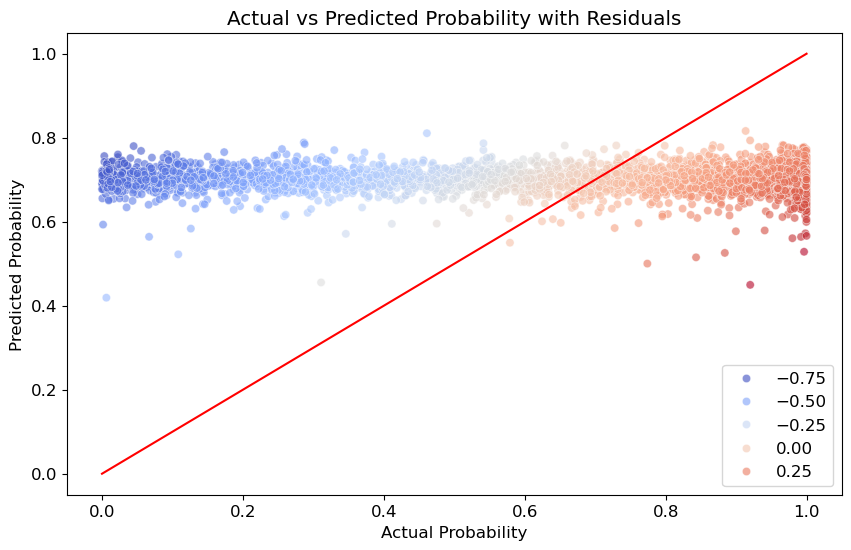

In [168]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_best_xgb = (y_test - y_pred_best_xgb)

# Trực quan
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=y_test, y=y_pred_best_xgb, hue=residuals_best_xgb, palette='coolwarm', alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')

plt.title('Actual vs Predicted Probability with Residuals')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.show()

## Evaluation on test set

There are three error metrics that are commonly used for evaluating and reporting the performance of a regression model; they are:

- Mean Absolute Error (MAE): It measures the average of the absolute differences between predicted and actual values. It’s a straightforward metric showing how far off predictions are in absolute terms.
- Mean Squared Error (MSE): It calculates the average of the squared differences between predicted and actual values. MSE penalizes larger errors more than MAE.
- Root Mean Squared Error (RMSE): It is the square root of the MSE. RMSE gives an idea of how large the errors are, in the same units as the target variable.
- Root Mean Squared Log Error (RMSLE): Similar to RMSE, but it applies the natural logarithm to predicted and actual values first. It’s useful when the target variable has exponential growth or when you care about relative errors rather than absolute differences.
- R Squared (R²): It measures the proportion of variance in the dependent variable that is predictable from the independent variables. A higher R² indicates a better fit of the model. It ranges from 0 (no fit) to 1 (perfect fit).

Reference: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metricstricsMAE)

In [173]:
# Các metrics đánh giá
metrics = {'Model': [], 'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}

# Mean Absolute Error (MAE) - Sai số tuyệt đối trung bình: MAE đo lường trung bình của các độ lệch tuyệt đối giữa giá trị dự đoán và giá trị thực tế.
# Mean Squared Error (MSE) - Sai số bình phương trung bình: MSE tính trung bình của các bình phương độ lệch giữa giá trị dự đoán và giá trị thực tế.
# Root Mean Squared Error (RMSE) - Căn bậc hai của sai số bình phương trung bình: RMSE là căn bậc hai của MSE, giúp đưa sai số về cùng đơn vị với biến mục tiêu.
# Root Mean Squared Log Error (RMSLE) - Căn bậc hai của sai số bình phương trung bình theo log: Giống như RMSE, nhưng trước khi tính toán, cả giá trị dự đoán và giá trị thực tế đều được chuyển đổi bằng hàm log tự nhiên. RMSLE phù hợp với các bài toán có biến mục tiêu tăng trưởng theo cấp số nhân hoặc khi sai số tương đối quan trọng hơn sai số tuyệt đối.
# R Squared (R²) - Hệ số xác định: R² đo lường tỷ lệ phương sai của biến phụ thuộc có thể giải thích được bởi các biến độc lập trong mô hình. Giá trị R² càng cao thì mô hình càng phù hợp, với phạm vi từ 0 (mô hình không giải thích được gì) đến 1 (mô hình hoàn hảo).

# Polynomial Regression
metrics['Model'].append('Polynomial Regression')
metrics['MAE'].append(mean_absolute_error(y_test, y_pred_best_poly))
metrics['MSE'].append(mean_squared_error(y_test, y_pred_best_poly))
metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred_best_poly)))
metrics['R2'].append(r2_score(y_test, y_pred_best_poly))

# Decision Tree Regression
metrics['Model'].append('Decision Tree Regression')
metrics['MAE'].append(mean_absolute_error(y_test, y_pred_best_tree))
metrics['MSE'].append(mean_squared_error(y_test, y_pred_best_tree))
metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred_best_tree)))
metrics['R2'].append(r2_score(y_test, y_pred_best_tree))

# Random Forest Regression
metrics['Model'].append('Random Forest Regression')
metrics['MAE'].append(mean_absolute_error(y_test, y_pred_best_rf))
metrics['MSE'].append(mean_squared_error(y_test, y_pred_best_rf))
metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred_best_rf)))
metrics['R2'].append(r2_score(y_test, y_pred_best_rf))

# XGBoost Regression
metrics['Model'].append('XGBoost Regression')
metrics['MAE'].append(mean_absolute_error(y_test, y_pred_best_xgb))
metrics['MSE'].append(mean_squared_error(y_test, y_pred_best_xgb))
metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred_best_xgb)))
metrics['R2'].append(r2_score(y_test, y_pred_best_xgb))

metrics_df = pd.DataFrame(metrics)
metrics_df

Model       MAE       MSE      RMSE        R2
0     Polynomial Regression  0.281022  0.106741  0.326712 -0.000635
1  Decision Tree Regression  0.281117  0.106907  0.326967 -0.002194
2  Random Forest Regression  0.281028  0.106758  0.326738 -0.000792
3        XGBoost Regression  0.281637  0.107447  0.327791 -0.007254

Since R² is negative, all models are ineffective. Even the best model (Polynomial Regression) is no better than simply predicting the mean.

**Conclusion:** Regarding the evaluation results of the four models, it is evident that the models fail to predict the delay probability of orders.

### Deployment Workflow Diagram

![workflow.png](workflow.png)

https://excalidraw.com/#json=UMXi7HaO9mX736_Bu-wEQ,8kpXRFSgNSFLZRcngGMGPg

## Data Pipeline

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier

numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7)), # Xử lý missing data bằng cách dự báo KNN với n=7
    ('scale', StandardScaler()), # Quy đổi tỷ lệ của các giá trị khác nhau để so sánh
    ('power', PowerTransformer(method='yeo-johnson')) # Biến đổi để phân phối của dữ liệu gần với phân phối chuẩn hơn
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, float_feature_variables)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scale', StandardScaler()),
                                                 ('power',
                                                  PowerTransformer())]),
                                 ['vehicle_gps_latitude',
                                  'vehicle_gps_longitude',
                                  'fuel_consumption_rate',
                                  'eta_variation_hours',
                                  'traffic_congestion_level',
                                  'warehouse_inventory_level',
                                  'loading_unloading_time',
                                  'handling_equipment_availability',
                                  'order_fulfillment_status',
                                  'weather_condition_severity',
                                  'port_congestion_level', 'shipping_costs',
                                  'supplier_reliability_score',
                                  'lead_time_days', 'historical_demand',
                                  'iot_temperature', 'cargo_condition_status',
                                  'route_risk_level', 'customs_clearance_time',
                                  'driver_behavior_score',
                                  'fatigue_monitoring_score'])])

In [ ]:
models = {
    "Polynomial Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor()
}

for name, regressor in models.items():
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    
    print(f"Training {name}...")
    model.fit(X_train, y_train)

Training Polynomial Regression...
Training Decision Tree...
Training Random Forest...
